# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Импорт

In [1]:
import os
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline
from sklearn.metrics import get_scorer
from sklearn.metrics import root_mean_squared_error

import time

### Функци, которые могут пригодиться

In [2]:
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [3]:
def scatter(data_orig, target, plot_cols):
    data=data_orig.select_dtypes(include = ['int64', 'float64'])
    data_sorted = data.sort_values(by = target)
    fig, axs = plt.subplots(
        nrows=math.ceil(len(data_sorted.columns)/plot_cols), ncols=plot_cols,
        figsize=(20, 2*len(data_sorted.columns)), 
    )
    i = 0
    k = 0
    while k < len(data_sorted.columns):
        for col in range(plot_cols):
            if k < len(data_sorted.columns):
                column_name = str(data_sorted.columns[k])
                axs[i, col].scatter(data_sorted[column_name],data_sorted[target], alpha=0.5)
                axs[i, col].grid(True)
                axs[i, col].set_title(f'{column_name}')
            k += 1
        i += 1   

In [4]:
def hist_boxplot_clear_of_outliers(data_orig, plot_cols):
    data=data_orig.select_dtypes(include = ['int64', 'float64'])
    if len(data.columns) % 2 == 0:
        x = int(2*len(data.columns)/plot_cols)
    else:
        x = int(2*(len(data.columns)+1)/plot_cols)
    fig, axs = plt.subplots(
        nrows=x, ncols=plot_cols,
        figsize=(20, 6*x), 
    )
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    i = 0
    k = 0
    while k < len(data.columns)+2:
        for col in range(plot_cols):
            if i%2 == 0:
                if  k < len(data.columns):
                    column_name = str(data.columns[k])
                    min_outline = (data[column_name].quantile(0.25) 
                                   - 1.5*(data[column_name].quantile(0.75) 
                                          - data[column_name].quantile(0.25)))
                    max_outline = (data[column_name].quantile(0.75) 
                                   + 1.5*(data[column_name].quantile(0.75)
                                           -data[column_name].quantile(0.25)))
                    col_temp = data.loc[
                        (data[column_name] > min_outline) &  (data[column_name] < max_outline)
                        ][column_name]
                    axs[i, col].hist(col_temp, edgecolor='black', range=(min(col_temp), max(col_temp)))
                    axs[i, col].grid(True)
                    axs[i, col].set_title(f'{column_name}',fontsize=14, fontweight="bold")
                    axs[i, col].set_ylabel(f'Количество значений {column_name}')
                    axs[i, col].set_xlabel(f'Диапазон значений {column_name} ',fontsize=14)
                    for j in axs[i, col].patches:
                        axs[i, col].annotate('%1.2f'%(j.get_height()), (j.get_x(), j.get_height()))
            else:
                if k % plot_cols == 0:
                    k -= plot_cols
                if  k < len(data.columns):
                    column_name = str(data.columns[k])
                    min_outline = (data[column_name].quantile(0.25) 
                                   - 1.5*(data[column_name].quantile(0.75) 
                                          - data[column_name].quantile(0.25)))
                    max_outline = (data[column_name].quantile(0.75) 
                                   + 1.5*(data[column_name].quantile(0.75)
                                           -data[column_name].quantile(0.25)))
                    col_temp = data.loc[
                        (data[column_name] > min_outline) &  (data[column_name] < max_outline)
                        ][column_name]
                    axs[i, col].boxplot(col_temp,vert=False)
                    axs[i, col].grid(True)
                    axs[i, col].set_xlabel(f'Диапазон значений {column_name} ', fontsize=14)
            k += 1
        i += 1    

In [5]:
def hist_boxplot(data_orig, plot_cols):
    data=data_orig.select_dtypes(include = ['int64', 'float64'])
    if len(data.columns) % 2 == 0:
        x = int(2*len(data.columns)/plot_cols)
    else:
        x = int(2*(len(data.columns)+1)/plot_cols)
    fig, axs = plt.subplots(
        nrows=x, ncols=plot_cols,
        figsize=(20, 6*x), 
    )
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    i = 0
    k = 0
    while k < len(data.columns)+2:
        for col in range(plot_cols):
            if i%2 == 0:
                if  k < len(data.columns):
                    column_name = str(data.columns[k])
                    axs[i, col].hist(data[column_name], edgecolor='black', range=(min(data[column_name]), max(data[column_name])))
                    axs[i, col].grid(True)
                    axs[i, col].set_title(f'{column_name}',fontsize=14, fontweight="bold")
                    axs[i, col].set_ylabel(f'Количество значений {column_name}')
                    axs[i, col].set_xlabel(f'Диапазон значений {column_name} ',fontsize=14)
                    for j in axs[i, col].patches:
                        axs[i, col].annotate('%1.2f'%(j.get_height()), (j.get_x(), j.get_height()))
            else:
                if k % plot_cols == 0:
                    k -= plot_cols
                if  k < len(data.columns):
                    column_name = str(data.columns[k])
                    axs[i, col].boxplot(data[column_name],vert=False)
                    axs[i, col].grid(True)
                    axs[i, col].set_xlabel(f'Диапазон значений {column_name} ', fontsize=14)
            k += 1
        i += 1  

## Подготовка данных 

In [6]:
autos = pd.read_csv('autos.csv')

### Изучение данных 

In [7]:
print(autos.shape)
autos.info()

(354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

In [8]:
autos.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

#### Преобразуем типы данных

In [9]:
autos['DateCrawled'] =  pd.to_datetime(autos['DateCrawled'])

In [10]:
autos['LastSeen'] =  pd.to_datetime(autos['LastSeen'])

In [11]:
autos['DateCreated'] =  pd.to_datetime(autos['DateCreated'])

In [12]:
autos['PostalCode'] =  autos['PostalCode'].astype('str')

In [13]:
autos.describe(percentiles=[0.02, 0.25, 0.5, 0.75, 0.9, 0.98])

DateCrawled          Price  RegistrationYear  \
count                         354369  354369.000000     354369.000000   
mean   2016-03-21 12:58:10.450648320    4416.656776       2004.234448   
min              2016-03-05 14:06:22       0.000000       1000.000000   
2%        2016-03-05 20:49:09.360000       0.000000       1987.000000   
25%              2016-03-13 11:52:33    1050.000000       1999.000000   
50%              2016-03-21 17:50:55    2700.000000       2003.000000   
75%              2016-03-29 14:37:20    6400.000000       2008.000000   
90%              2016-04-02 20:49:13   11450.000000       2012.000000   
98%       2016-04-04 22:52:08.280000   17499.000000       2017.000000   
max              2016-04-07 14:36:58   20000.000000       9999.000000   
std                              NaN    4514.158514         90.227958   

               Power      Kilometer  RegistrationMonth  \
count  354369.000000  354369.000000      354369.000000   
mean      110.094337  128211.172535           5.714645   
min         0.000000    5000.000000           0.000000   
2%          0.000000   10000.000000           0.000000   
25%        69.000000  125000.000000           3.000000   
50%       105.000000  150000.000000           6.000000   
75%       143.000000  150000.000000           9.000000   
90%       179.000000  150000.000000          11.000000   
98%       258.000000  150000.000000          12.000000   
max     20000.000000  150000.000000          12.000000   
std       189.850405   37905.341530           3.726421   

                         DateCreated  NumberOfPictures  \
count                         354369          354369.0   
mean   2016-03-20 19:12:07.753274112               0.0   
min              2014-03-10 00:00:00               0.0   
2%               2016-03-05 00:00:00               0.0   
25%              2016-03-13 00:00:00               0.0   
50%              2016-03-21 00:00:00               0.0   
75%              2016-03-29 00:00:00               0.0   
90%              2016-04-02 00:00:00               0.0   
98%              2016-04-04 00:00:00               0.0   
max              2016-04-07 00:00:00               0.0   
std                              NaN               0.0   

                            LastSeen  
count                         354369  
mean   2016-03-29 23:51:00.667456768  
min              2016-03-05 14:15:08  
2%        2016-03-09 05:16:41.360000  
25%              2016-03-23 02:50:03  
50%              2016-04-03 15:15:51  
75%              2016-04-06 10:15:19  
90%              2016-04-07 02:46:59  
98%              2016-04-07 11:46:34  
max              2016-04-07 14:58:51  
std                              NaN

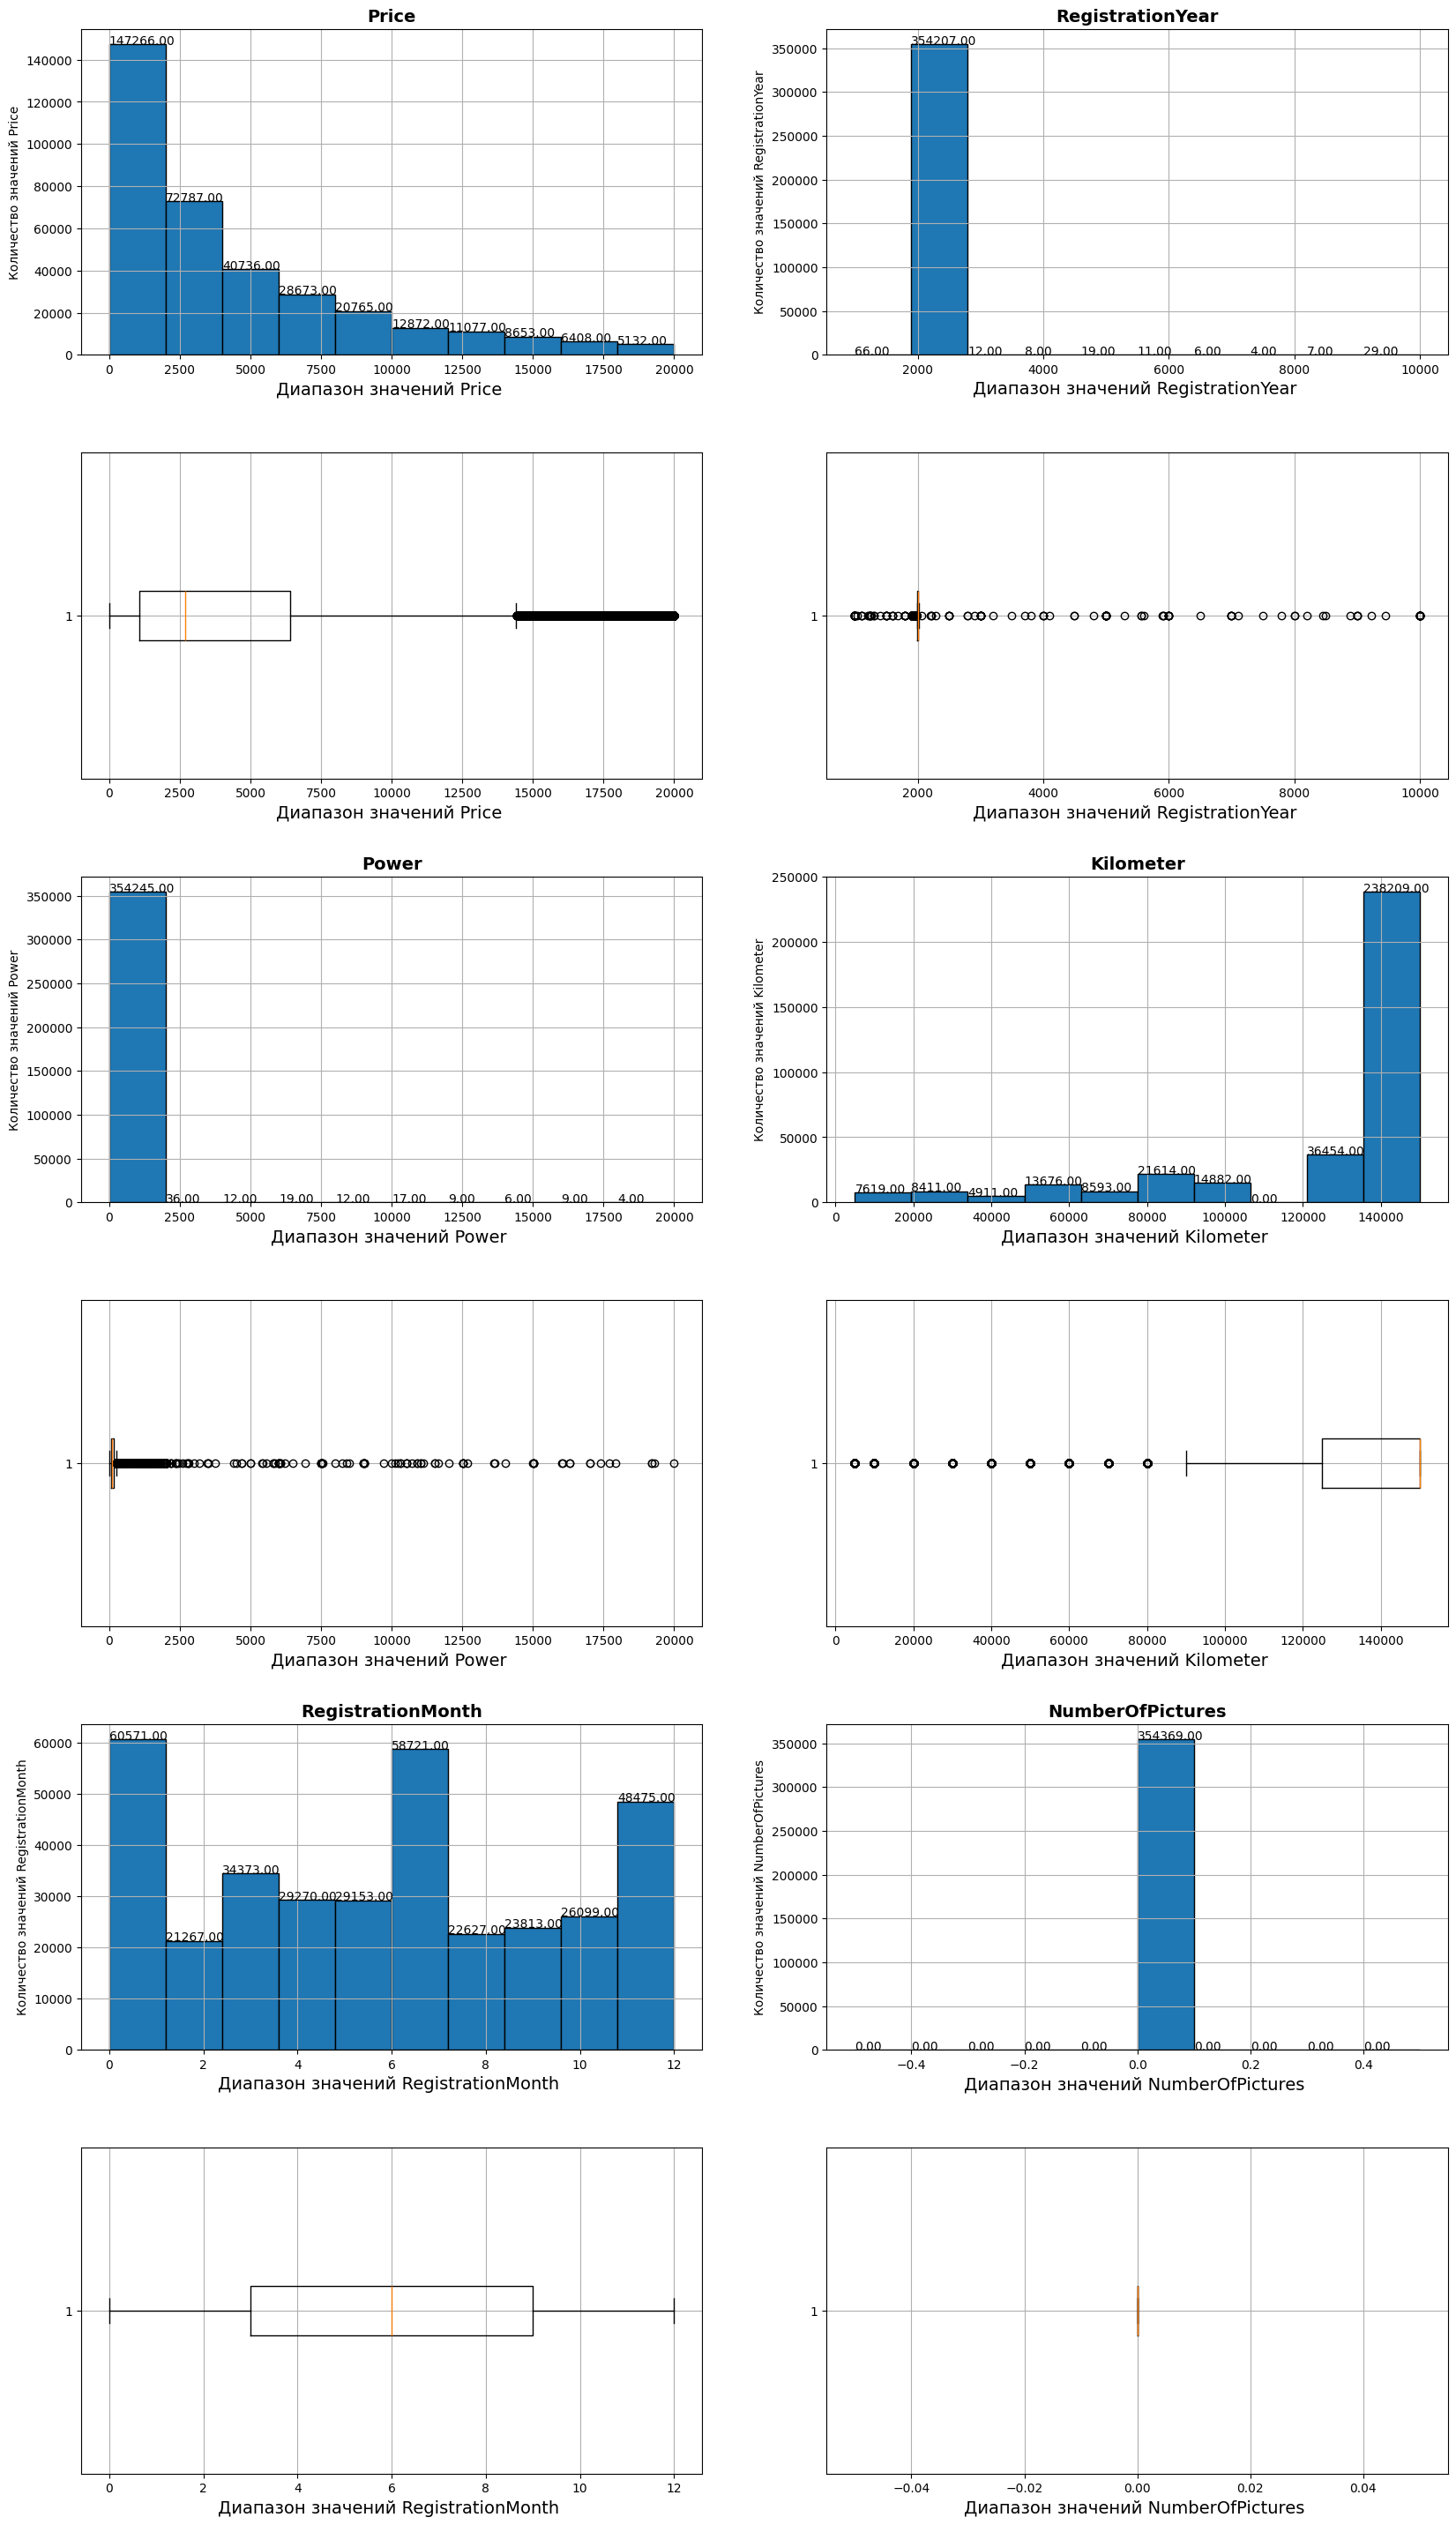

In [14]:
hist_boxplot(autos, 2)

### Обработка дубликатов

In [15]:
autos.duplicated().sum()

4

In [16]:
autos = autos.drop_duplicates()
autos.shape

(354365, 16)

### Обработка пропусков 

In [17]:
autos = autos[autos.columns]
autos['num_nulls'] = autos[autos.columns].isnull().sum(axis=1)
autos.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0 2016-03-24 11:52:17    480         NaN              1993  manual      0   
1 2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2 2016-03-14 12:52:21   9800         suv              2004    auto    163   
3 2016-03-17 16:54:04   1500       small              2001  manual     75   
4 2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

  DateCreated  NumberOfPictures PostalCode            LastSeen  num_nulls  
0  2016-03-24                 0      70435 2016-04-07 03:16:57          2  
1  2016-03-24                 0      66954 2016-04-07 01:46:50          1  
2  2016-03-14                 0      90480 2016-04-05 12:47:46          1  
3  2016-03-17                 0      91074 2016-03-17 17:40:17          0  
4  2016-03-31                 0      60437 2016-04-06 10:17:21          0

In [18]:
autos['num_nulls'].describe(percentiles=[0.05, 0.10, 0.65, 0.7,  0.9, 0.95])

count    354365.000000
mean          0.510990
std           0.943049
min           0.000000
5%            0.000000
10%           0.000000
50%           0.000000
65%           0.000000
70%           1.000000
90%           2.000000
95%           3.000000
max           5.000000
Name: num_nulls, dtype: float64

удалим строки где нет сведений ни о бренде ни о модели

In [19]:
autos = autos.query('Brand == Brand or Model == Model')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [20]:
autos['num_nulls'].describe(percentiles=[0.05, 0.10, 0.65, 0.7,  0.9, 0.95])

count    354365.000000
mean          0.510990
std           0.943049
min           0.000000
5%            0.000000
10%           0.000000
50%           0.000000
65%           0.000000
70%           1.000000
90%           2.000000
95%           3.000000
max           5.000000
Name: num_nulls, dtype: float64

Остальные строки пока трогать не будем

### Обработка неинформативных признаков

#### NumberOfPictures

Очевидно, что неинформативным признакам относится столбец NumberOfPictures, где все значения нулевые. 
Удалим его

In [21]:
autos = autos.drop('NumberOfPictures', axis=1)

#### LastSeen, DateCrawled, DateCreated

In [22]:
autos['LastSeen'].min()

Timestamp('2016-03-05 14:15:08')

In [23]:
autos['LastSeen'].max()

Timestamp('2016-04-07 14:58:51')

In [24]:
autos['DateCrawled'].min()

Timestamp('2016-03-05 14:06:22')

In [25]:
autos['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [26]:
autos['DateCreated'].min()

Timestamp('2014-03-10 00:00:00')

In [27]:
autos['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

##### DateCrawled

Так как значений в столбце DateCrawled очень много, в целях анализа на информативность сгруппиуем их тремя способами 
1. по дням месяца
2. по дням недели
3. по часам

In [28]:
### часы
autos['DateCrawled_hour'] = autos['DateCrawled'].dt.hour
### дни недели    
autos['DateCrawled_day_w'] = autos['DateCrawled'].dt.weekday
### дни месяца
autos['DateCrawled_day_m'] = autos['DateCrawled'].dt.day

Корреляция цены и часа = 0.017556765522915217
Корреляция цены и дня недели = 0.017510381354317945
Корреляция цены и дня месяца = -0.0067545003609262


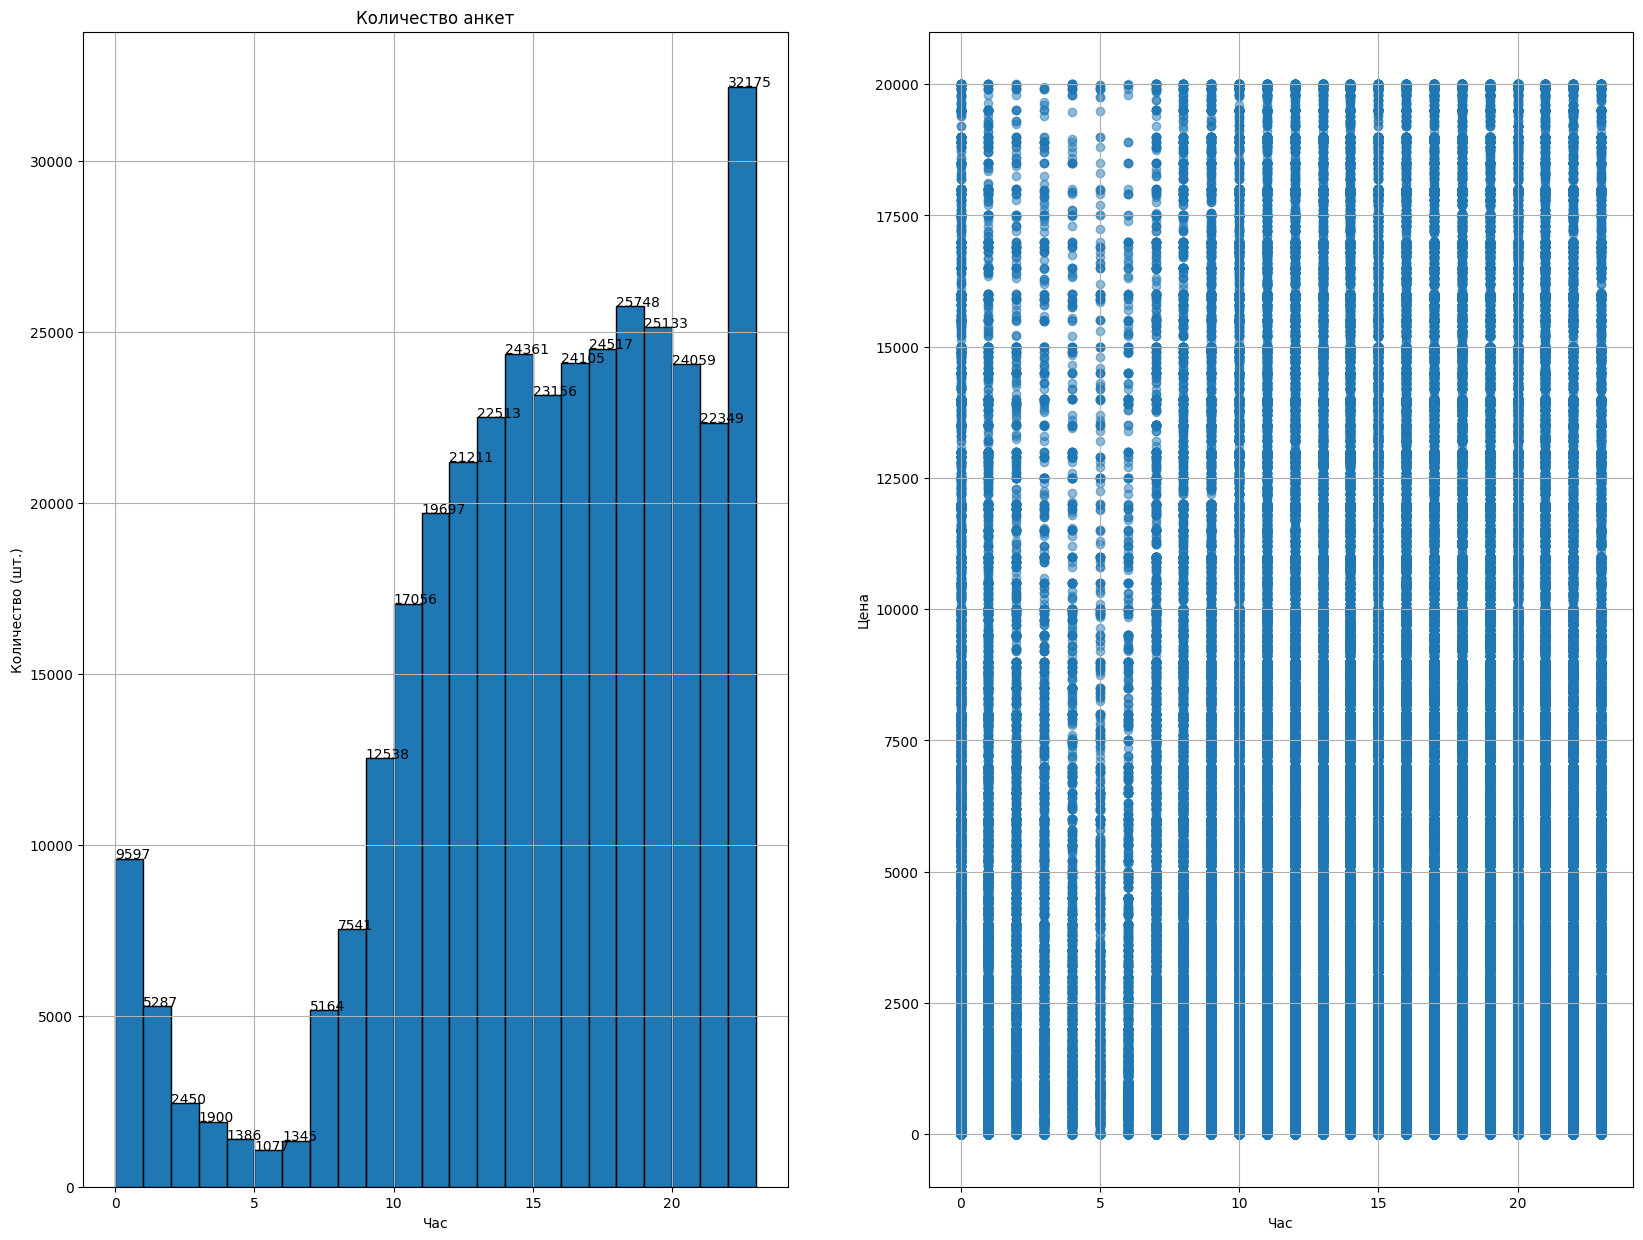

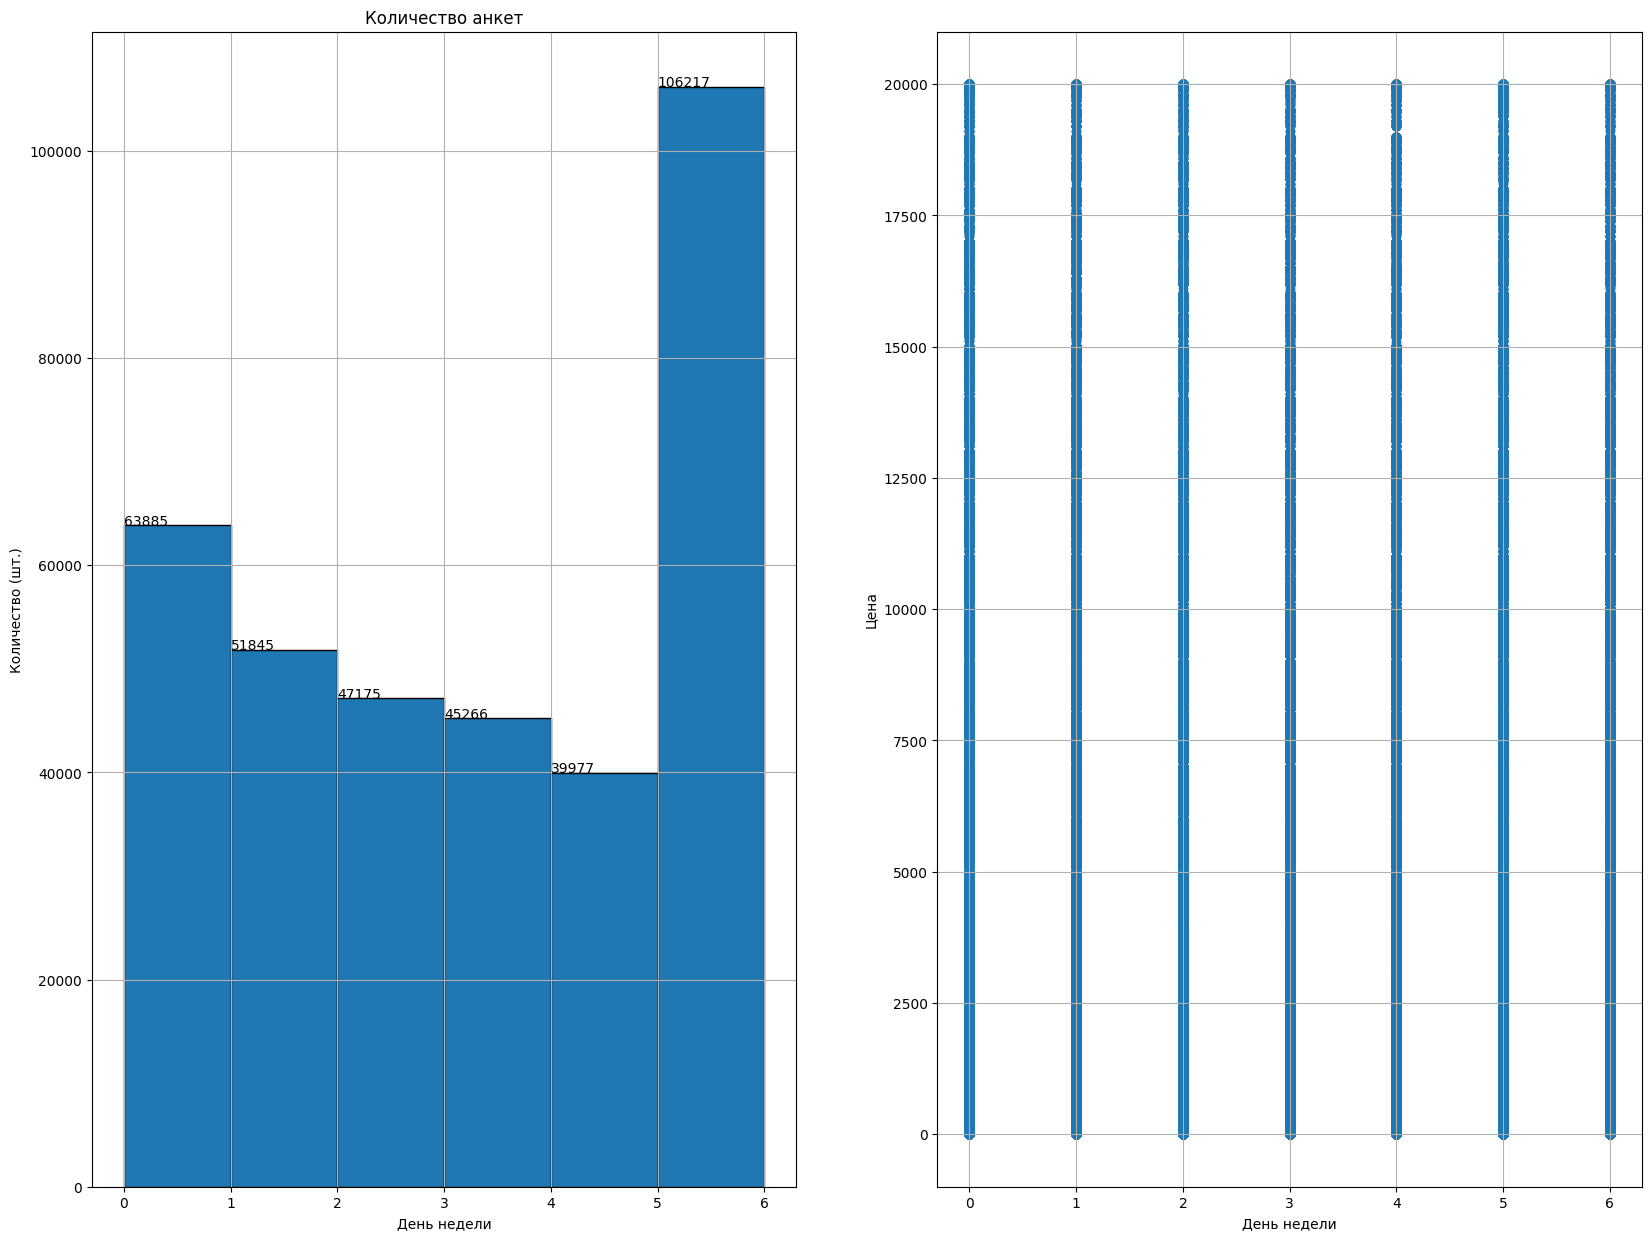

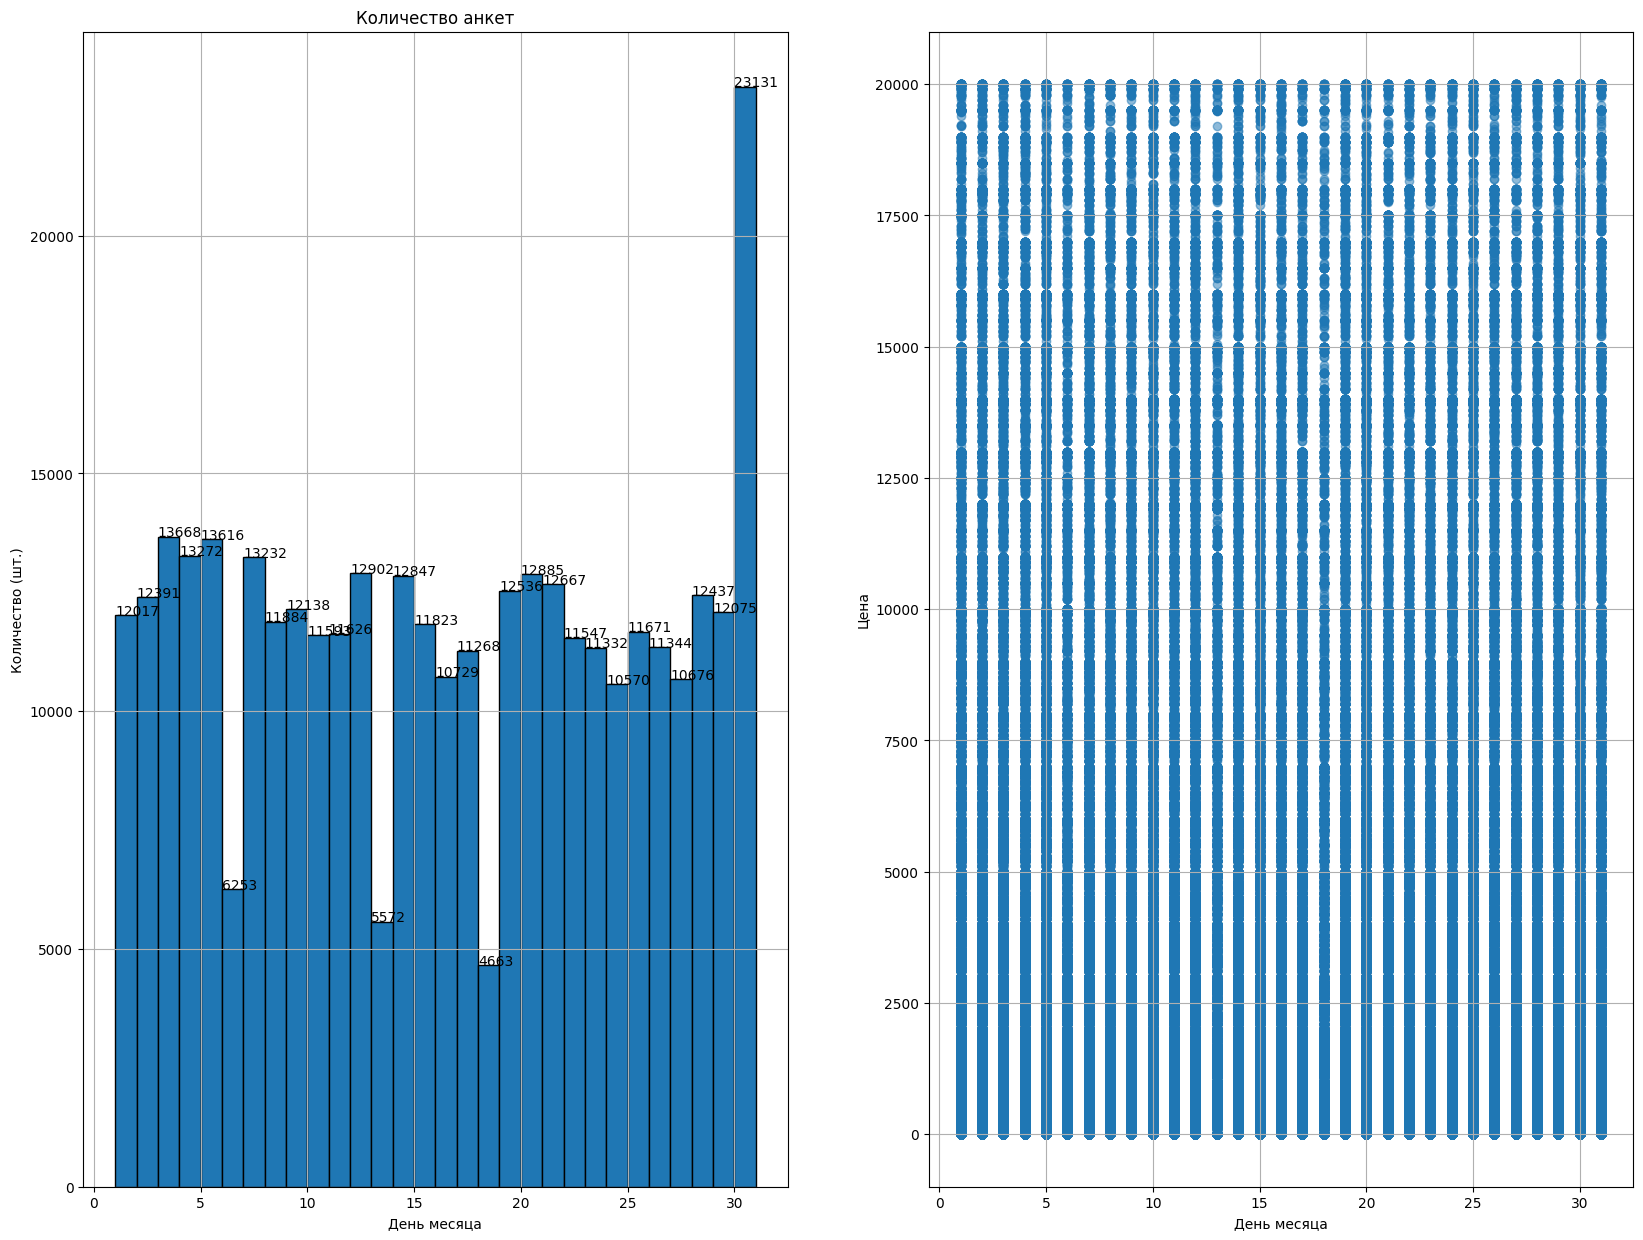

In [29]:
### часы
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
)

axs[0].hist(
    autos['DateCrawled_hour'],
    edgecolor='black',
    bins=range(autos['DateCrawled_hour'].min(),autos['DateCrawled_hour'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Час')

axs[1].scatter(autos['DateCrawled_hour'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Час')

print('Корреляция цены и часа =', autos['Price'].corr(autos['DateCrawled_hour']))

### дни недели    

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['DateCrawled_day_w'],
    edgecolor='black',
    bins=range(autos['DateCrawled_day_w'].min(),autos['DateCrawled_day_w'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День недели')

axs[1].scatter(autos['DateCrawled_day_w'], autos['Price'])
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День недели')

print('Корреляция цены и дня недели =', autos['Price'].corr(autos['DateCrawled_day_w']))

### дни месяца

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['DateCrawled_day_m'],
    edgecolor='black',
    bins=range(autos['DateCrawled_day_m'].min(),autos['DateCrawled_day_m'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День месяца')

axs[1].scatter(autos['DateCrawled_day_m'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День месяца')

print('Корреляция цены и дня месяца =', autos['Price'].corr(autos['DateCrawled_day_m']))

In [30]:
autos['DateCrawled_day_w'].unique()

array([3, 0, 4, 5, 1, 6, 2])

Каких-либо взаимосвязей найти не удалось, удалим столбец DateCrawled и все созданные на его основе

In [31]:
autos = autos.drop(['DateCrawled','DateCrawled_hour','DateCrawled_day_m','DateCrawled_day_w' ], axis=1)

##### LastSeen

изучим таким же образом столбец  LastSeen

In [32]:
### часы
autos['LastSeen_hour'] = autos['LastSeen'].dt.hour
### дни недели    
autos['LastSeen_day_w'] = autos['LastSeen'].dt.weekday
### дни месяца
autos['LastSeen_day_m'] = autos['LastSeen'].dt.day

Корреляция цены и часа = -0.02009355858751078
Корреляция цены и дня недели = -0.04610836896799905
Корреляция цены и дня месяца = -0.10338694476889623


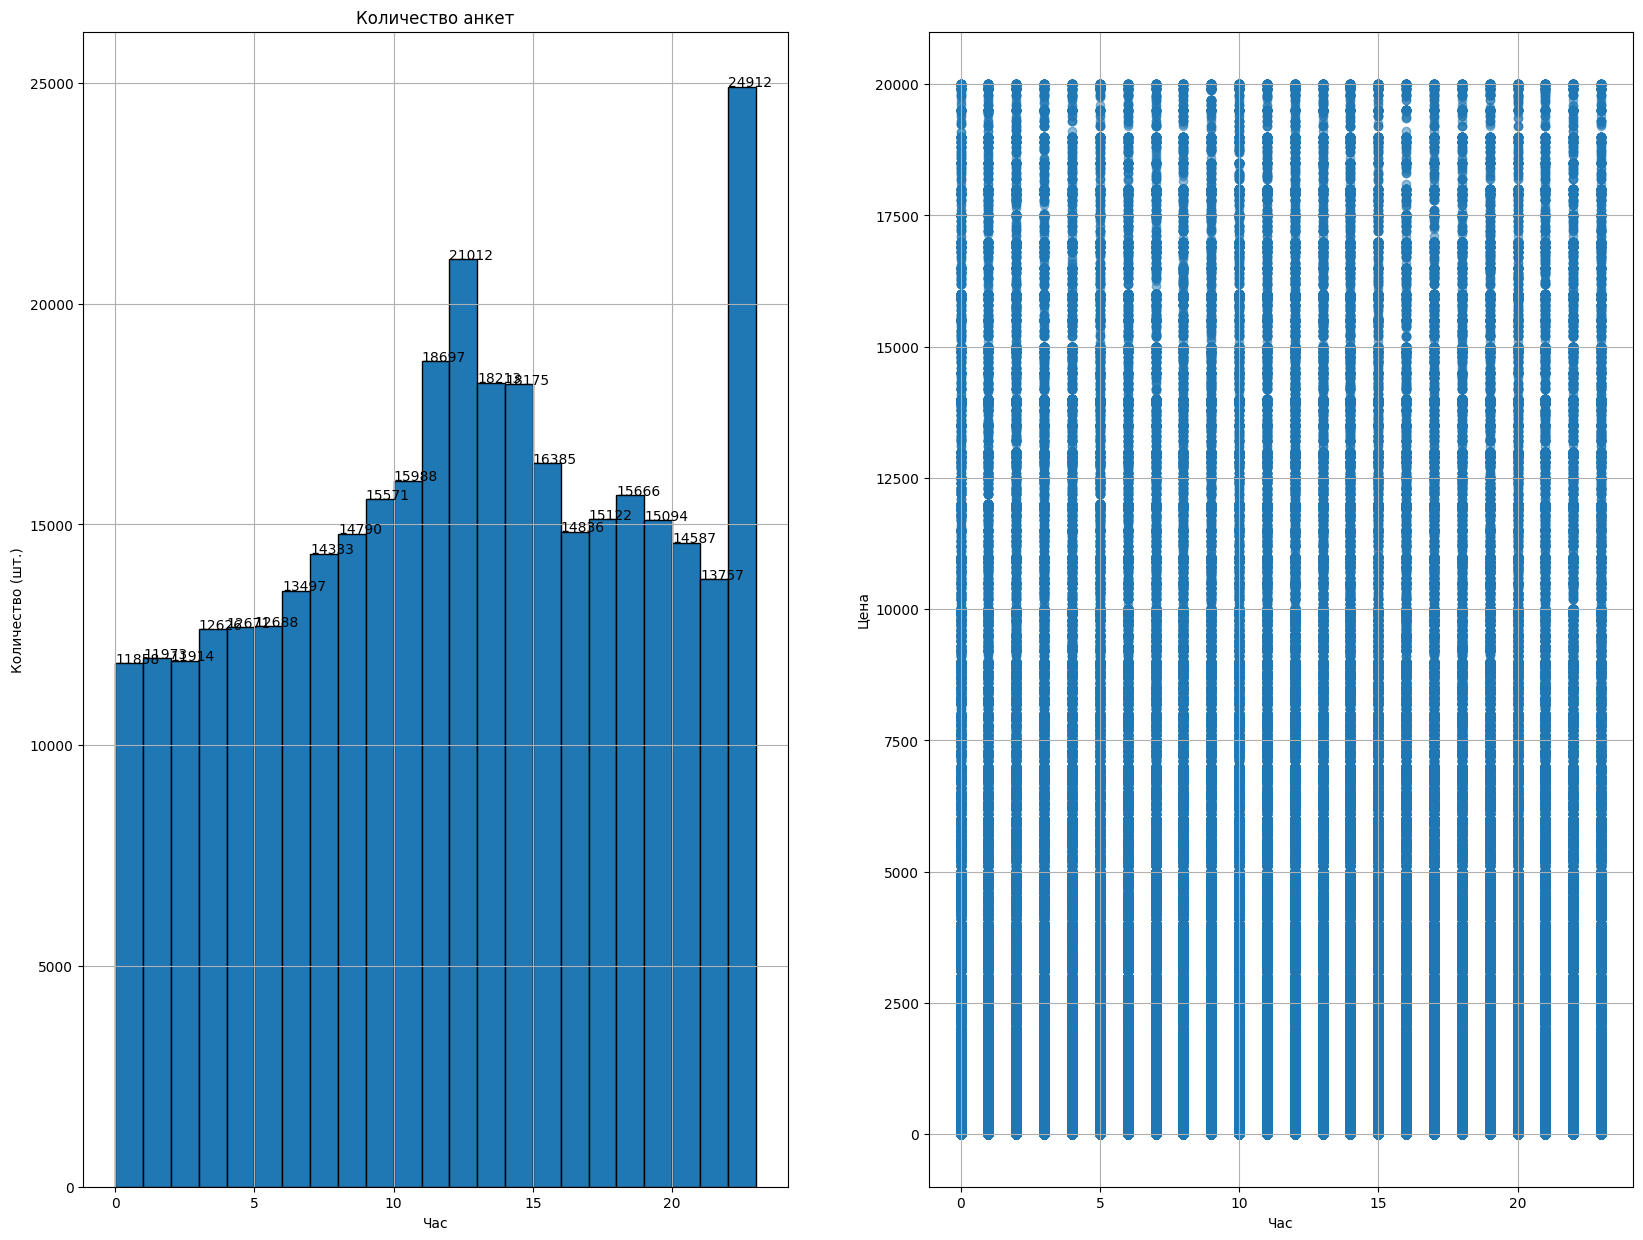

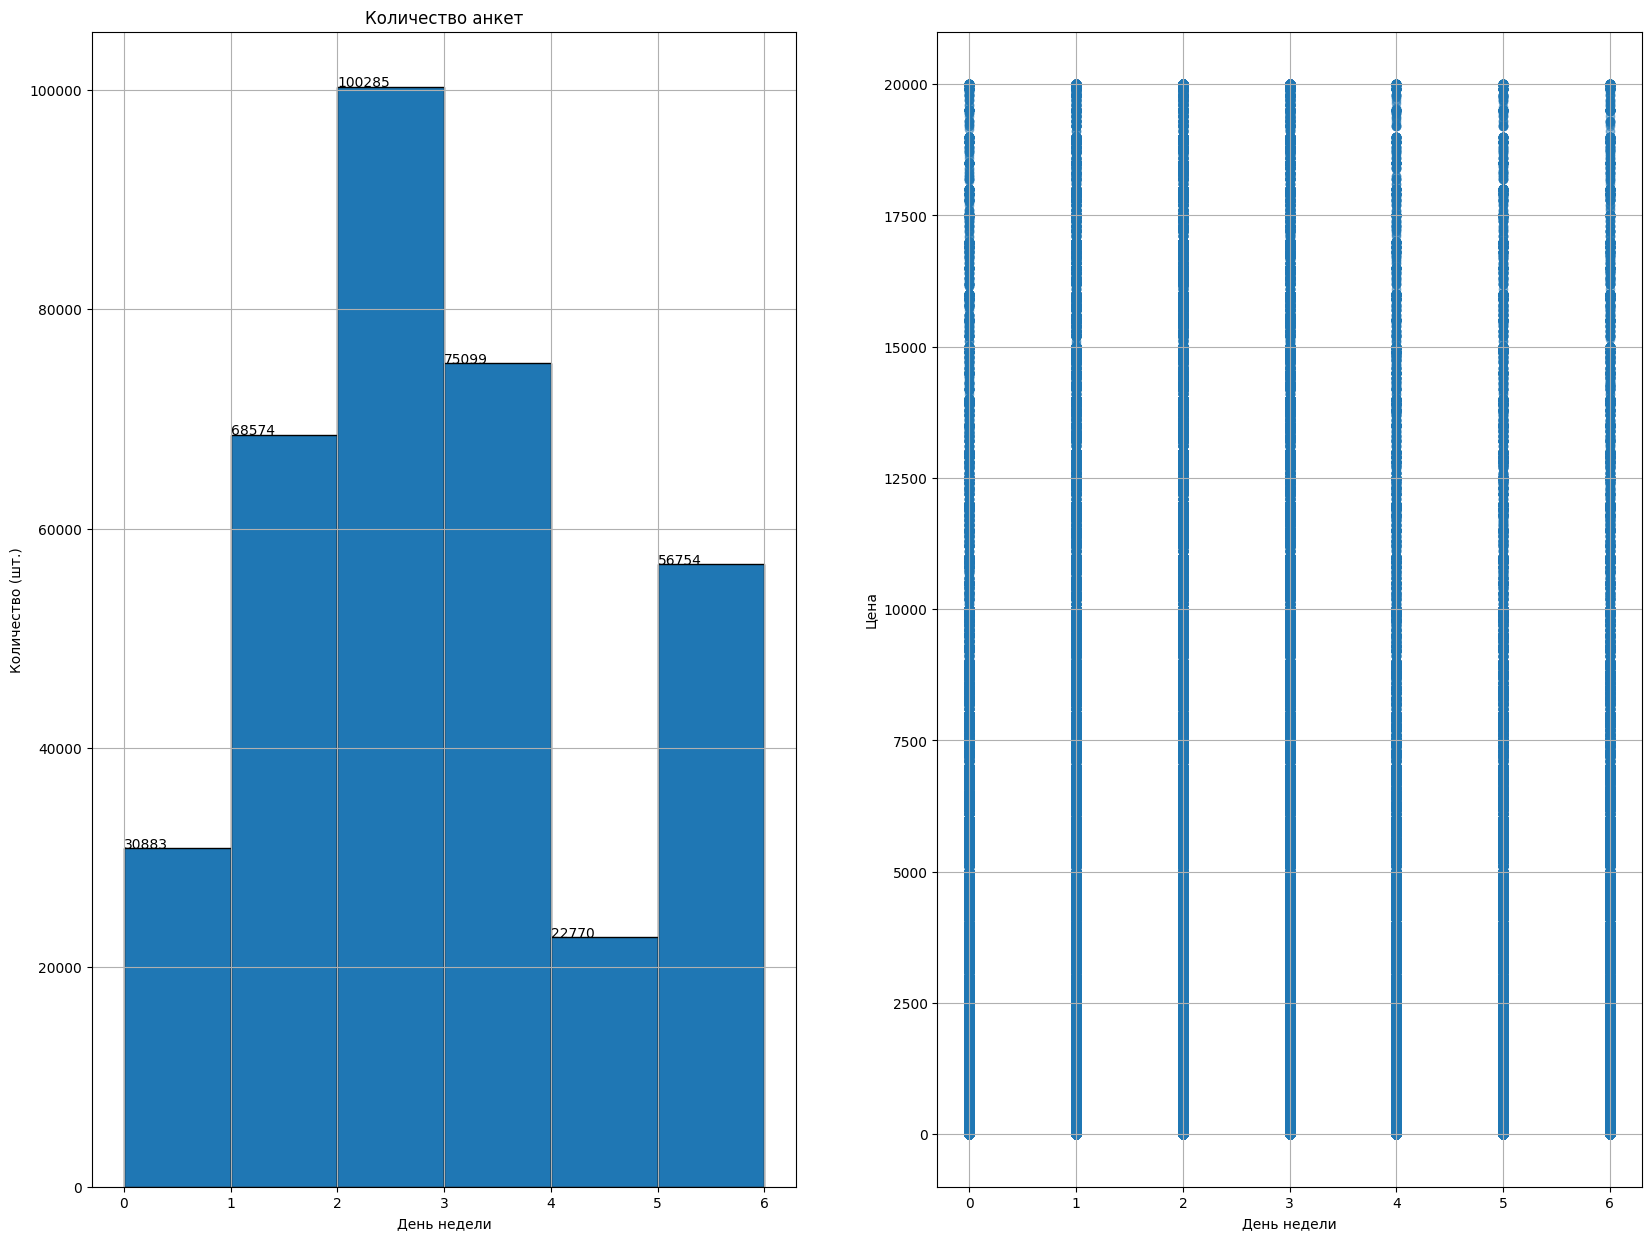

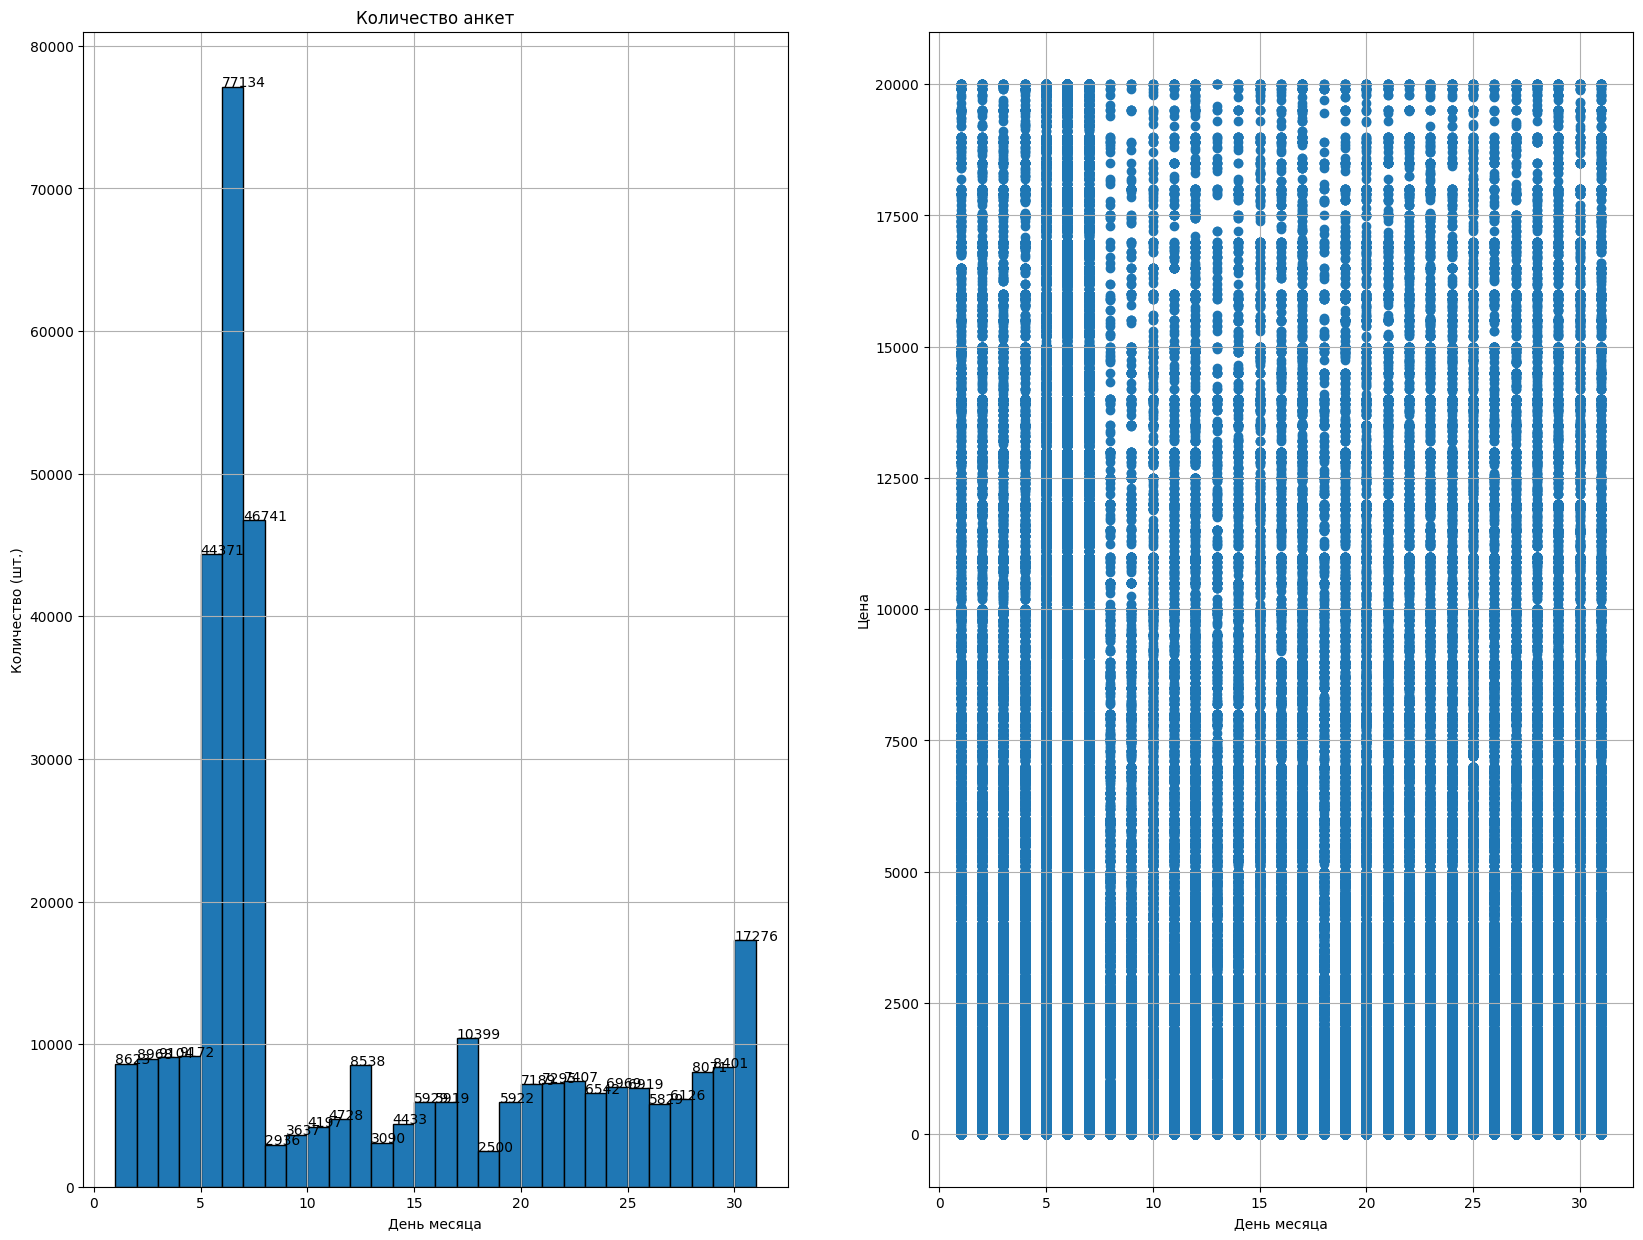

In [33]:
### часы
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
)

axs[0].hist(
    autos['LastSeen_hour'],
    edgecolor='black',
    bins=range(autos['LastSeen_hour'].min(),autos['LastSeen_hour'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Час')

axs[1].scatter(autos['LastSeen_hour'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Час')

print('Корреляция цены и часа =', autos['Price'].corr(autos['LastSeen_hour']))

### дни недели    

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['LastSeen_day_w'],
    edgecolor='black',
    bins=range(autos['LastSeen_day_w'].min(),autos['LastSeen_day_w'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День недели')

axs[1].scatter(autos['LastSeen_day_w'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День недели')

print('Корреляция цены и дня недели =', autos['Price'].corr(autos['LastSeen_day_w']))

### дни месяца

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['LastSeen_day_m'],
    edgecolor='black',
    bins=range(autos['LastSeen_day_m'].min(),autos['LastSeen_day_m'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День месяца')

axs[1].scatter(autos['LastSeen_day_m'], autos['Price'])
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День месяца')

print('Корреляция цены и дня месяца =', autos['Price'].corr(autos['LastSeen_day_m']))

Каких-либо взаимосвязей найти не удалось, удалим столбец LastSeen и все созданные на его основе

In [34]:
autos = autos.drop(['LastSeen','LastSeen_hour','LastSeen_day_m','LastSeen_day_w' ], axis=1)

##### DateCreated

изучим таким же образом столбец  DateCreated, удалив часы и добавив месяцы

In [35]:
### дни недели    
autos['DateCreated_day_w'] = autos['DateCreated'].dt.weekday
### дни месяца
autos['DateCreated_day_m'] = autos['DateCreated'].dt.day
### месяцы
autos['DateCreated_ym'] = pd.to_datetime(autos['DateCreated'], format='%Y.%m')



In [36]:
print('Корреляция цены и дня недели =', autos['Price'].corr(autos['DateCreated_day_w']))
print('Корреляция цены и дня месяца =', autos['Price'].corr(autos['DateCreated_day_m']))

Корреляция цены и дня недели = 0.018298863033053683
Корреляция цены и дня месяца = -0.0057926042923636695


Text(0.5, 0, 'Месяц')

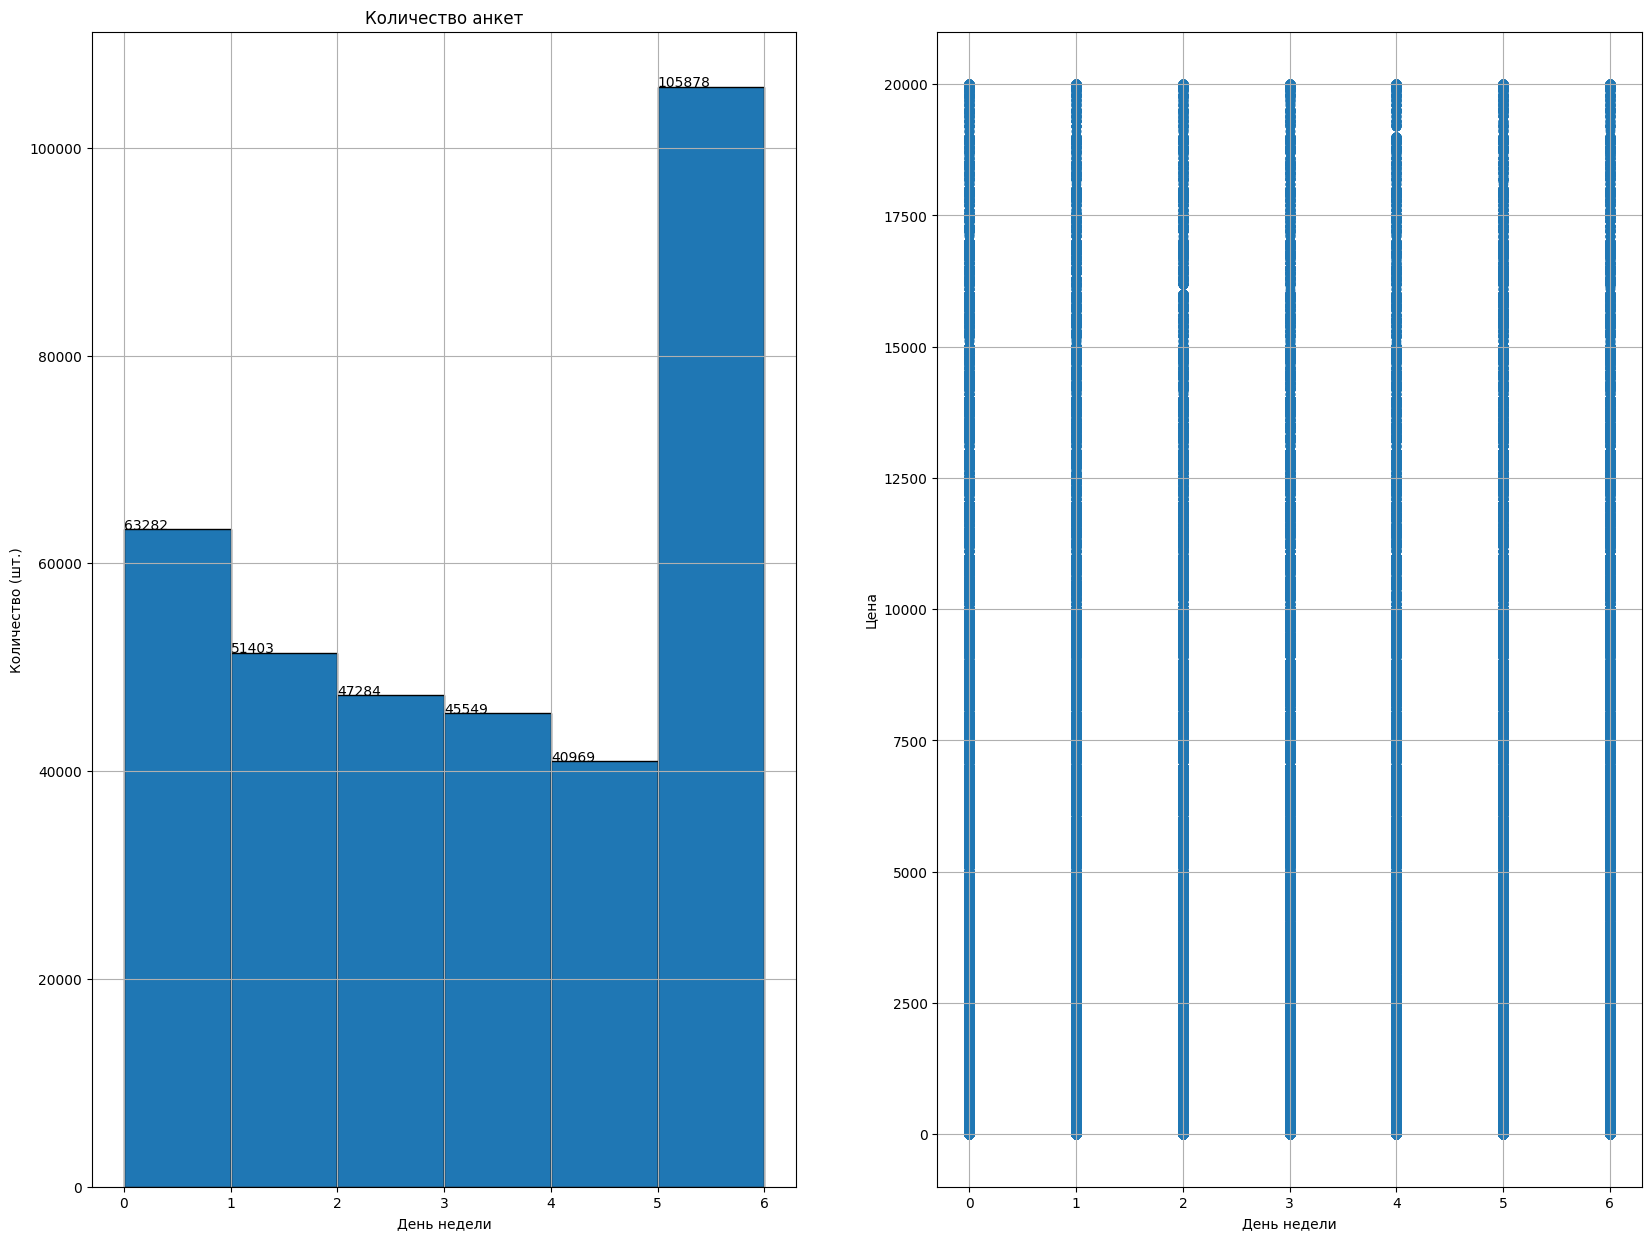

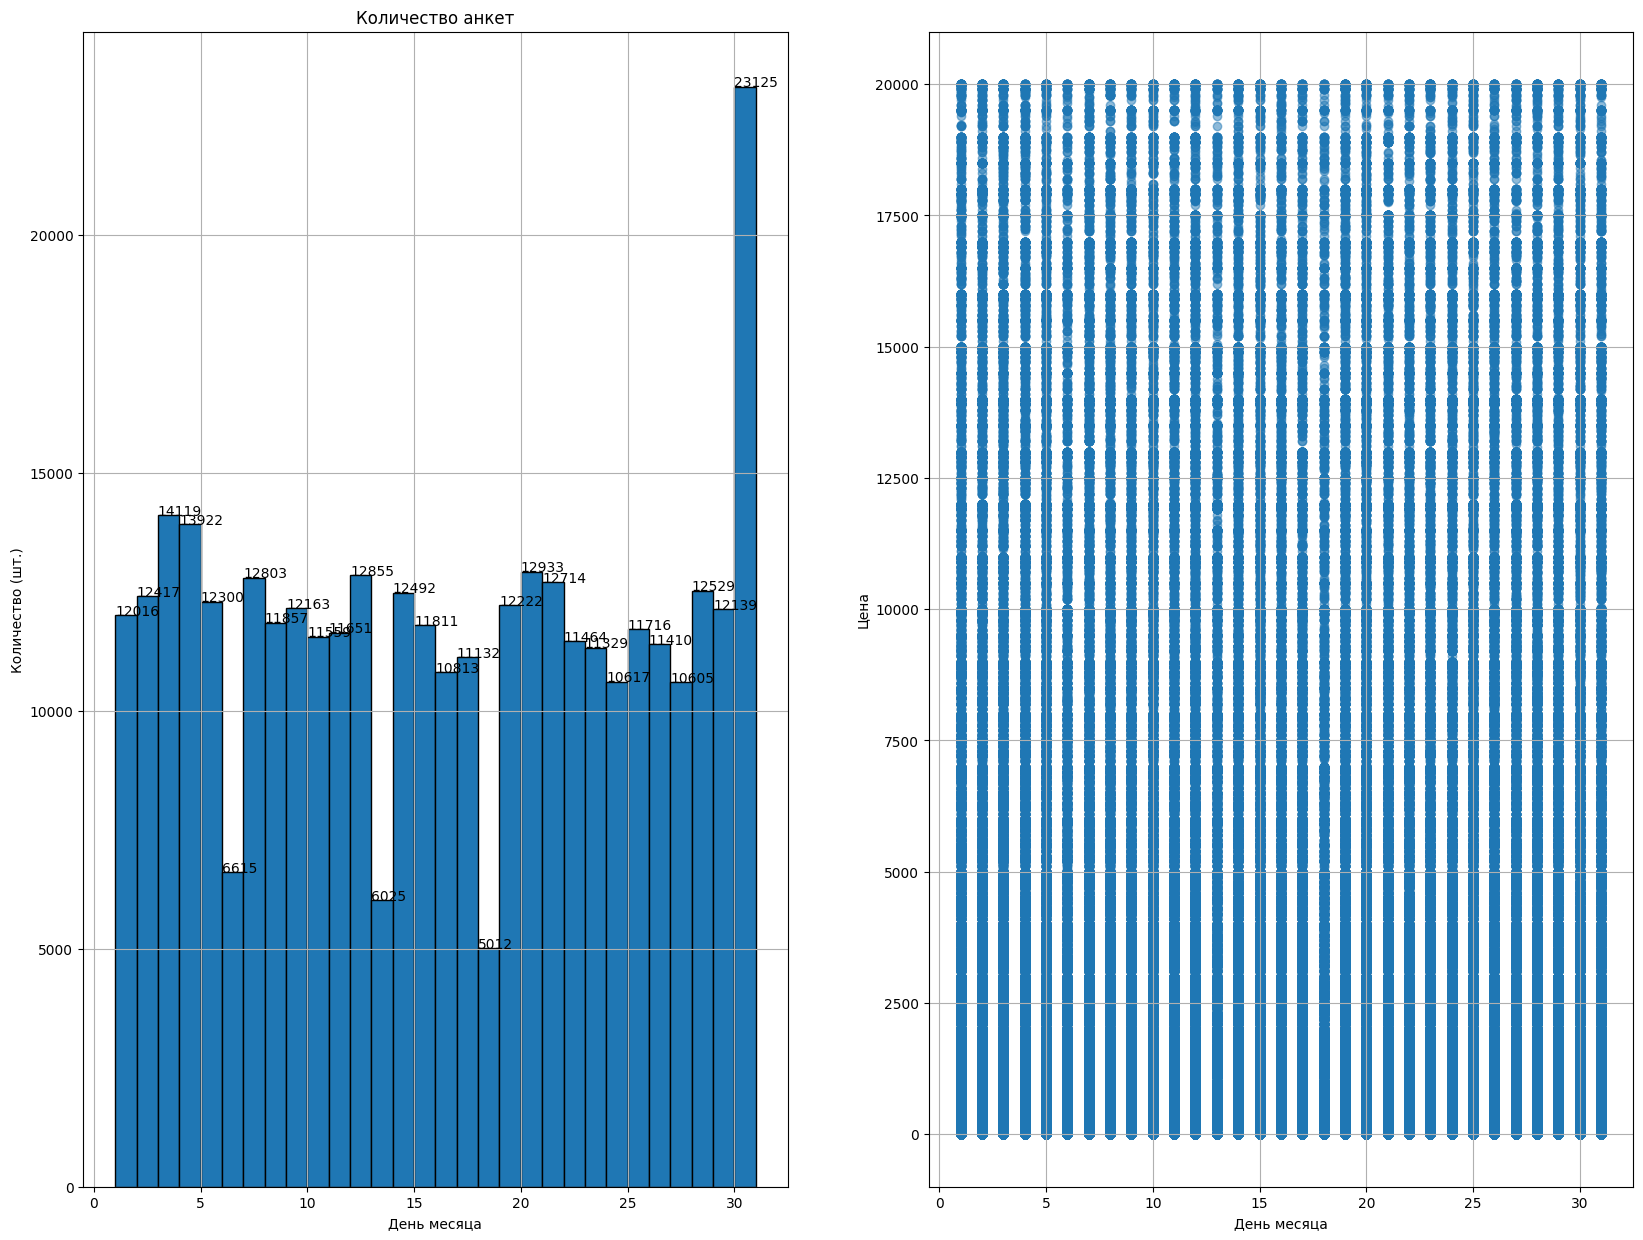

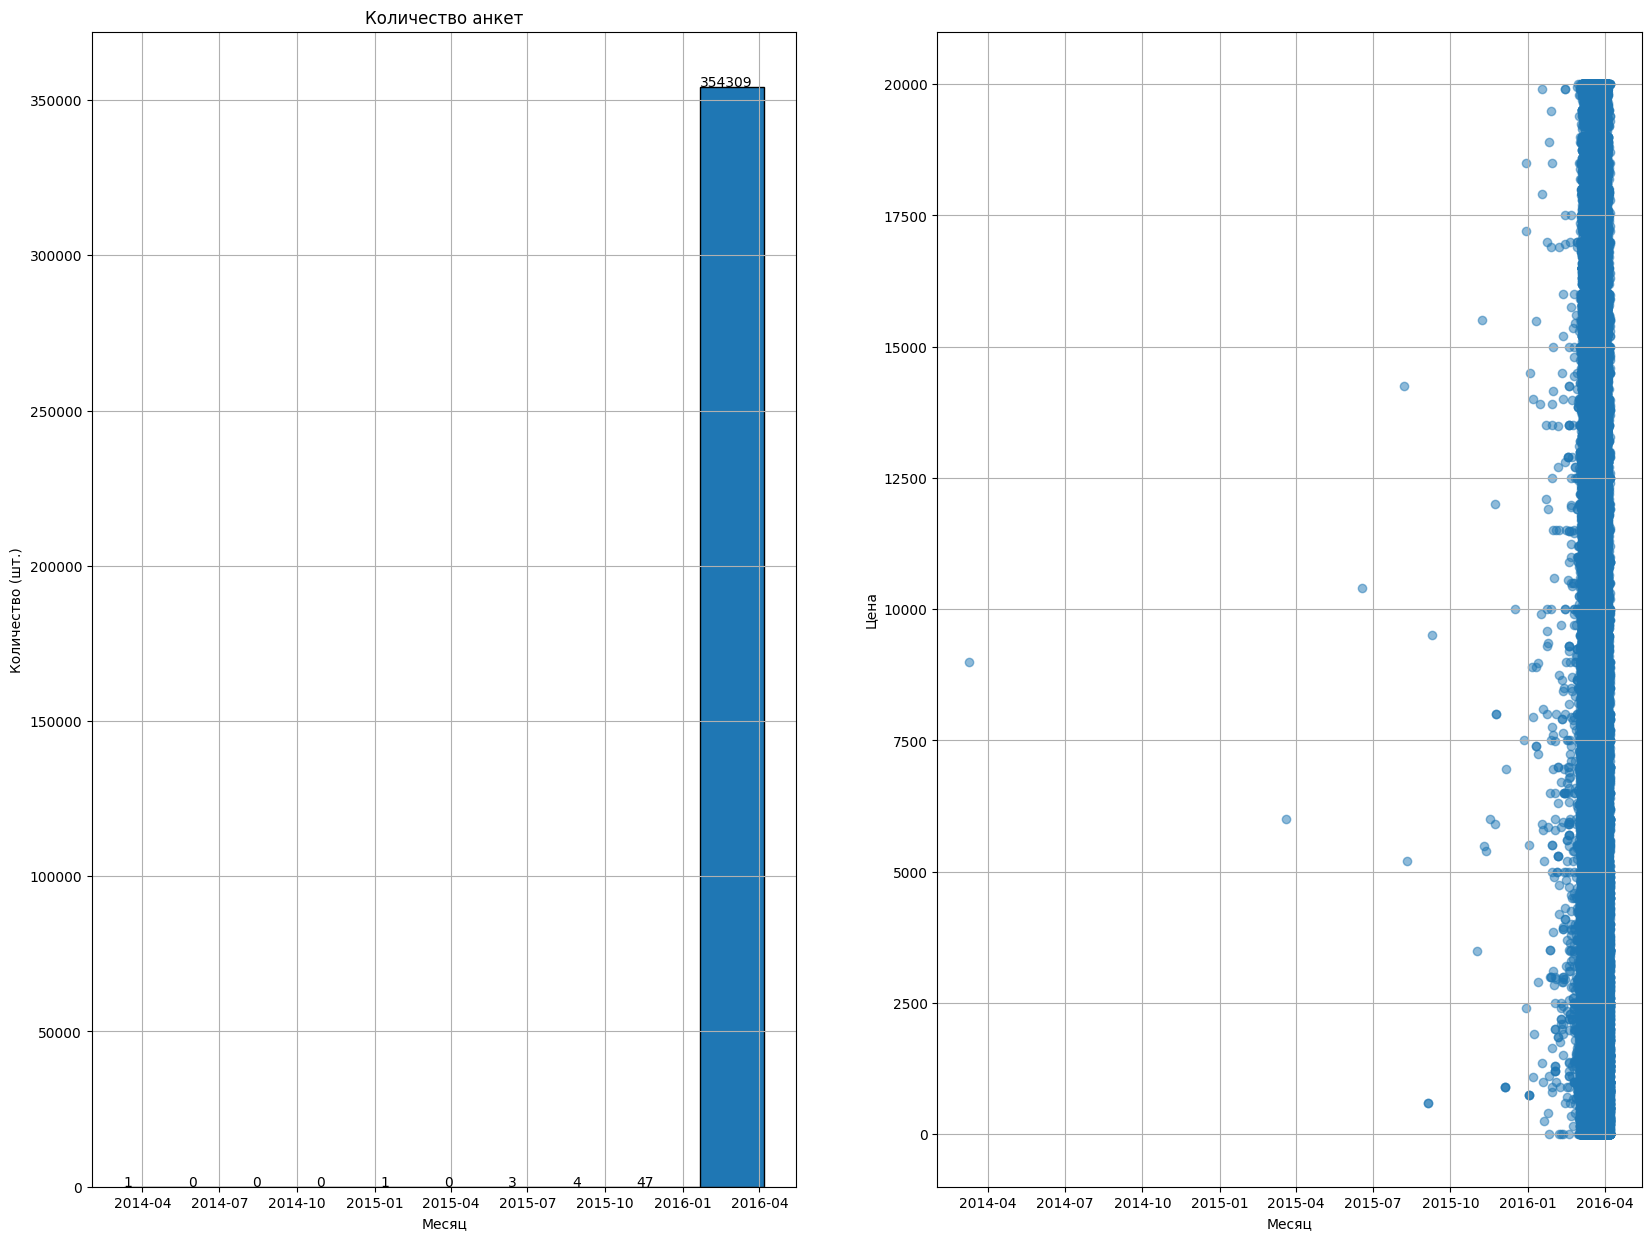

In [37]:
### дни недели    

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['DateCreated_day_w'],
    edgecolor='black',
    bins=range(autos['DateCreated_day_w'].min(),autos['DateCreated_day_w'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День недели')

axs[1].scatter(autos['DateCreated_day_w'], autos['Price'])
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День недели')



### дни месяца

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['DateCreated_day_m'],
    edgecolor='black',
    bins=range(autos['DateCreated_day_m'].min(),autos['DateCreated_day_m'].max()+1, 1)
)
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('День месяца')

axs[1].scatter(autos['DateCreated_day_m'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('День месяца')

### месяцы

fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['DateCreated_ym'],
    edgecolor='black')
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Месяц')

axs[1].scatter(autos['DateCreated_ym'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Месяц')


Каких-либо взаимосвязей найти не удалось, удалим столбцы на созданные на основе 'DateCreated'

In [38]:
autos = autos.drop(['DateCreated_day_m','DateCreated_day_w' ], axis=1)

In [39]:
autos.head()

Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
0    480         NaN              1993  manual      0   golf     150000   
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

   RegistrationMonth  FuelType       Brand Repaired DateCreated PostalCode  \
0                  0    petrol  volkswagen      NaN  2016-03-24      70435   
1                  5  gasoline        audi      yes  2016-03-24      66954   
2                  8  gasoline        jeep      NaN  2016-03-14      90480   
3                  6    petrol  volkswagen       no  2016-03-17      91074   
4                  7  gasoline       skoda       no  2016-03-31      60437   

   num_nulls DateCreated_ym  
0          2     2016-03-24  
1          1     2016-03-24  
2          1     2016-03-14  
3          0     2016-03-17  
4          0     2016-03-31

#### PostalCode

In [40]:
autos['PostalCode'].nunique()

8143

Скорее всего столбец с почтовыми индексами также не информативен. Возможно также стоило бы как-нибудь группировать индексы, но для этого надо иметь предствление о регионах, к которым индексы относятся.

In [41]:
autos = autos.drop('PostalCode', axis=1)

#### RegistrationMonth

Проверим влияет или на цену месяц регистрации автомобиля

In [42]:
autos_month = autos.pivot_table(index='RegistrationMonth', values ='Price', aggfunc = ['count','mean', 'median'])
autos_month

count         mean  median
                   Price        Price   Price
RegistrationMonth                            
0                  37352  1907.968757   900.0
1                  23218  4671.043888  2900.0
2                  21267  4581.080218  2900.0
3                  34373  4585.424228  2899.0
4                  29270  4744.656577  3000.0
5                  29153  4623.699345  2990.0
6                  31507  4706.367093  2999.0
7                  27211  4798.685054  3000.0
8                  22627  4665.058691  2999.0
9                  23813  4874.961660  3250.0
10                 26099  4806.705008  3200.0
11                 24186  4904.757422  3250.0
12                 24289  4615.490469  2989.0

Text(0.5, 0, 'Месяц')

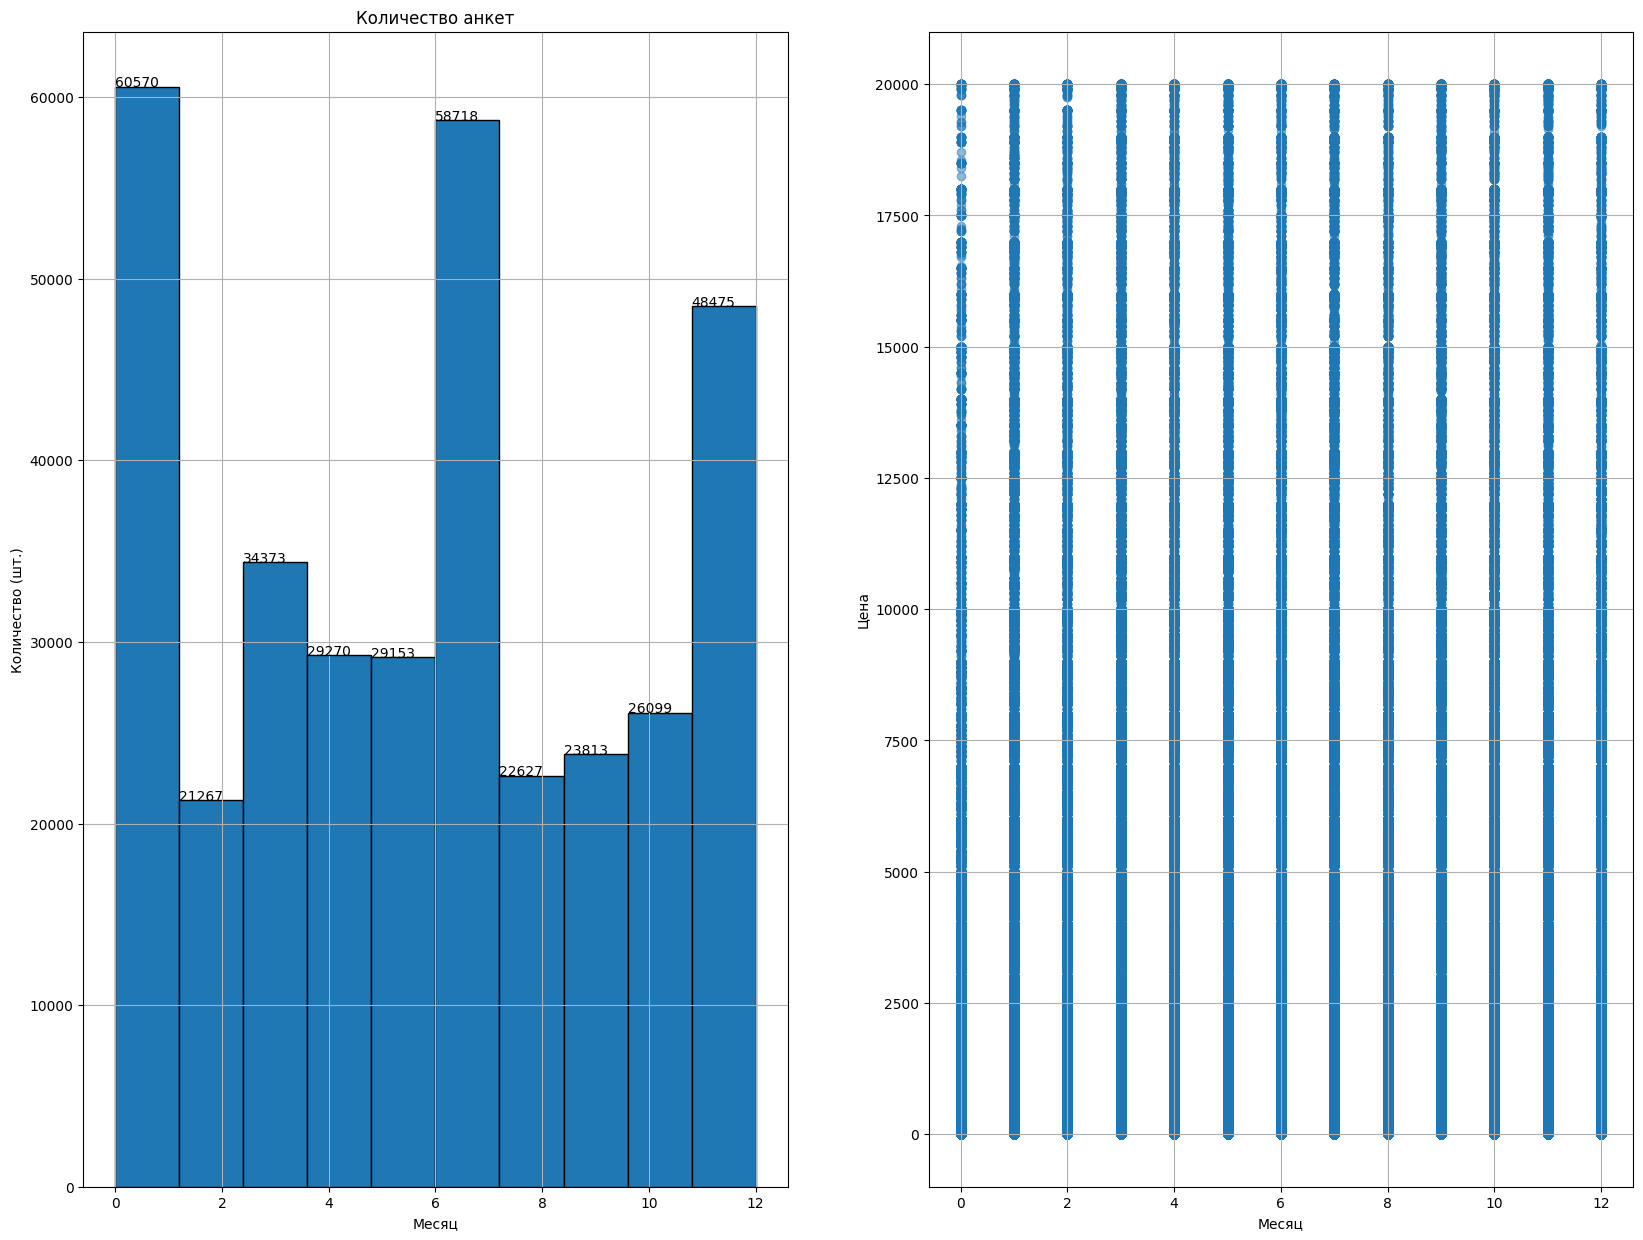

In [43]:
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 15)
) 
    
axs[0].hist(
    autos['RegistrationMonth'],
    edgecolor='black')
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Месяц')

axs[1].scatter(autos['RegistrationMonth'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Месяц')

Хотя корреляция скорее всего отсутвует, пока не будем удалять этот столбец, так как надо понять что за нулевой месяц и влияет указание нулевого месяца на качество других данных

### Обработка аномальных значений

#### Нулевые Price и Power

Удалим строки с нулевой ценой и (или) мощностью, как заведомо ошибочные

In [44]:
autos = autos.query('Price > 0 and Power > 0 ')
autos.describe(percentiles=[0.02, 0.25, 0.5, 0.75, 0.9, 0.98])

Price  RegistrationYear          Power      Kilometer  \
count  307233.000000     307233.000000  307233.000000  307233.000000   
mean     4809.878809       2003.524579     124.136105  128404.012590   
min         1.000000       1000.000000       1.000000    5000.000000   
2%        250.000000       1989.000000      50.000000   20000.000000   
25%      1300.000000       1999.000000      75.000000  125000.000000   
50%      3100.000000       2003.000000     110.000000  150000.000000   
75%      6950.000000       2008.000000     150.000000  150000.000000   
90%     11990.000000       2012.000000     190.000000  150000.000000   
98%     17700.000000       2017.000000     265.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   
std      4586.543041         33.641467     194.862560   36768.344715   

       RegistrationMonth                    DateCreated      num_nulls  \
count      307233.000000                         307233  307233.000000   
mean            5.963018  2016-03-20 19:29:12.245364480       0.348355   
min             0.000000            2015-03-20 00:00:00       0.000000   
2%              0.000000            2016-03-05 00:00:00       0.000000   
25%             3.000000            2016-03-13 00:00:00       0.000000   
50%             6.000000            2016-03-21 00:00:00       0.000000   
75%             9.000000            2016-03-29 00:00:00       0.000000   
90%            11.000000            2016-04-02 00:00:00       1.000000   
98%            12.000000            2016-04-04 00:00:00       3.000000   
max            12.000000            2016-04-07 00:00:00       5.000000   
std             3.600559                            NaN       0.715465   

                      DateCreated_ym  
count                         307233  
mean   2016-03-20 19:29:12.245364480  
min              2015-03-20 00:00:00  
2%               2016-03-05 00:00:00  
25%              2016-03-13 00:00:00  
50%              2016-03-21 00:00:00  
75%              2016-03-29 00:00:00  
90%              2016-04-02 00:00:00  
98%              2016-04-04 00:00:00  
max              2016-04-07 00:00:00  
std                              NaN

#### RegistrationYear

Найдем анкеты в которых регистрация автомобиля произошла позже даты регистрации анкеты

In [45]:
autos['DateCreated_y'] = autos['DateCreated'].dt.year
autos['DateCreated_m'] = autos['DateCreated'].dt.month

In [46]:
autos['DateCreated_ym'] = autos['DateCreated_y'].astype('int64') + autos['DateCreated_m'].astype('int64')/10
autos['DateCreated_ym']

1         2016.3
2         2016.3
3         2016.3
4         2016.3
5         2016.4
           ...  
354361    2016.3
354362    2016.3
354366    2016.3
354367    2016.3
354368    2016.3
Name: DateCreated_ym, Length: 307233, dtype: float64

In [47]:
autos['Registration_ym'] = autos['RegistrationYear'].astype('int64') + autos['RegistrationMonth'].astype('int64')/10
autos['Registration_ym']

1         2011.5
2         2004.8
3         2001.6
4         2008.7
5         1996.0
           ...  
354361    2017.2
354362    2004.5
354366    2000.3
354367    1996.3
354368    2002.6
Name: Registration_ym, Length: 307233, dtype: float64

In [48]:
autos1 = autos.query('DateCreated_ym < Registration_ym')
autos1

Price VehicleType  RegistrationYear Gearbox  Power   Model  Kilometer  \
22       2900         NaN              2018  manual     90  meriva     150000   
26       5555         NaN              2017  manual    125      c4     125000   
31        899         NaN              2016  manual     60    clio     150000   
35        350         NaN              2016  manual     75    golf     150000   
48       7750         NaN              2017  manual     80    golf     100000   
...       ...         ...               ...     ...    ...     ...        ...   
354115    299         NaN              2016  manual     60   astra     150000   
354140   1000         NaN              2017  manual    101      a4     150000   
354203   2140         NaN              2018  manual     80  fiesta     150000   
354289   5000         NaN              2017  manual    120   other     150000   
354361   5250         NaN              2016    auto    150     159     150000   

        RegistrationMonth FuelType       Brand Repaired DateCreated  \
22                      5   petrol        opel       no  2016-03-23   
26                      4      NaN     citroen       no  2016-03-10   
31                      6   petrol     renault      NaN  2016-03-29   
35                      4   petrol  volkswagen       no  2016-03-08   
48                      1   petrol  volkswagen      NaN  2016-03-25   
...                   ...      ...         ...      ...         ...   
354115                  4   petrol        opel      yes  2016-03-07   
354140                  9      NaN        audi      NaN  2016-03-29   
354203                  6      NaN        ford       no  2016-03-17   
354289                  7      NaN     citroen      yes  2016-03-05   
354361                 12      NaN  alfa_romeo       no  2016-03-09   

        num_nulls  DateCreated_ym  DateCreated_y  DateCreated_m  \
22              1          2016.3           2016              3   
26              2          2016.3           2016              3   
31              2          2016.3           2016              3   
35              1          2016.3           2016              3   
48              2          2016.3           2016              3   
...           ...             ...            ...            ...   
354115          1          2016.3           2016              3   
354140          3          2016.3           2016              3   
354203          2          2016.3           2016              3   
354289          2          2016.3           2016              3   
354361          2          2016.3           2016              3   

        Registration_ym  
22               2018.5  
26               2017.4  
31               2016.6  
35               2016.4  
48               2017.1  
...                 ...  
354115           2016.4  
354140           2017.9  
354203           2018.6  
354289           2017.7  
354361           2017.2  

[14091 rows x 17 columns]

In [49]:
autos1 = autos1[autos1.columns]
autos1['num_nulls'] = autos1[autos1.columns].isnull().sum(axis=1)
autos1['num_nulls'].describe(percentiles=[0.01, 0.02,0.10, 0.95, 0.98,  0.99, 0.995])

count    14091.00000
mean         1.99191
std          0.83590
min          0.00000
1%           1.00000
2%           1.00000
10%          1.00000
50%          2.00000
95%          3.00000
98%          4.00000
99%          4.00000
99.5%        4.00000
max          5.00000
Name: num_nulls, dtype: float64

Помимо неправильных дат в этих строках еще и достаточно много пропусков - удалим их

In [50]:
autos = autos.query('DateCreated_ym >= Registration_ym')

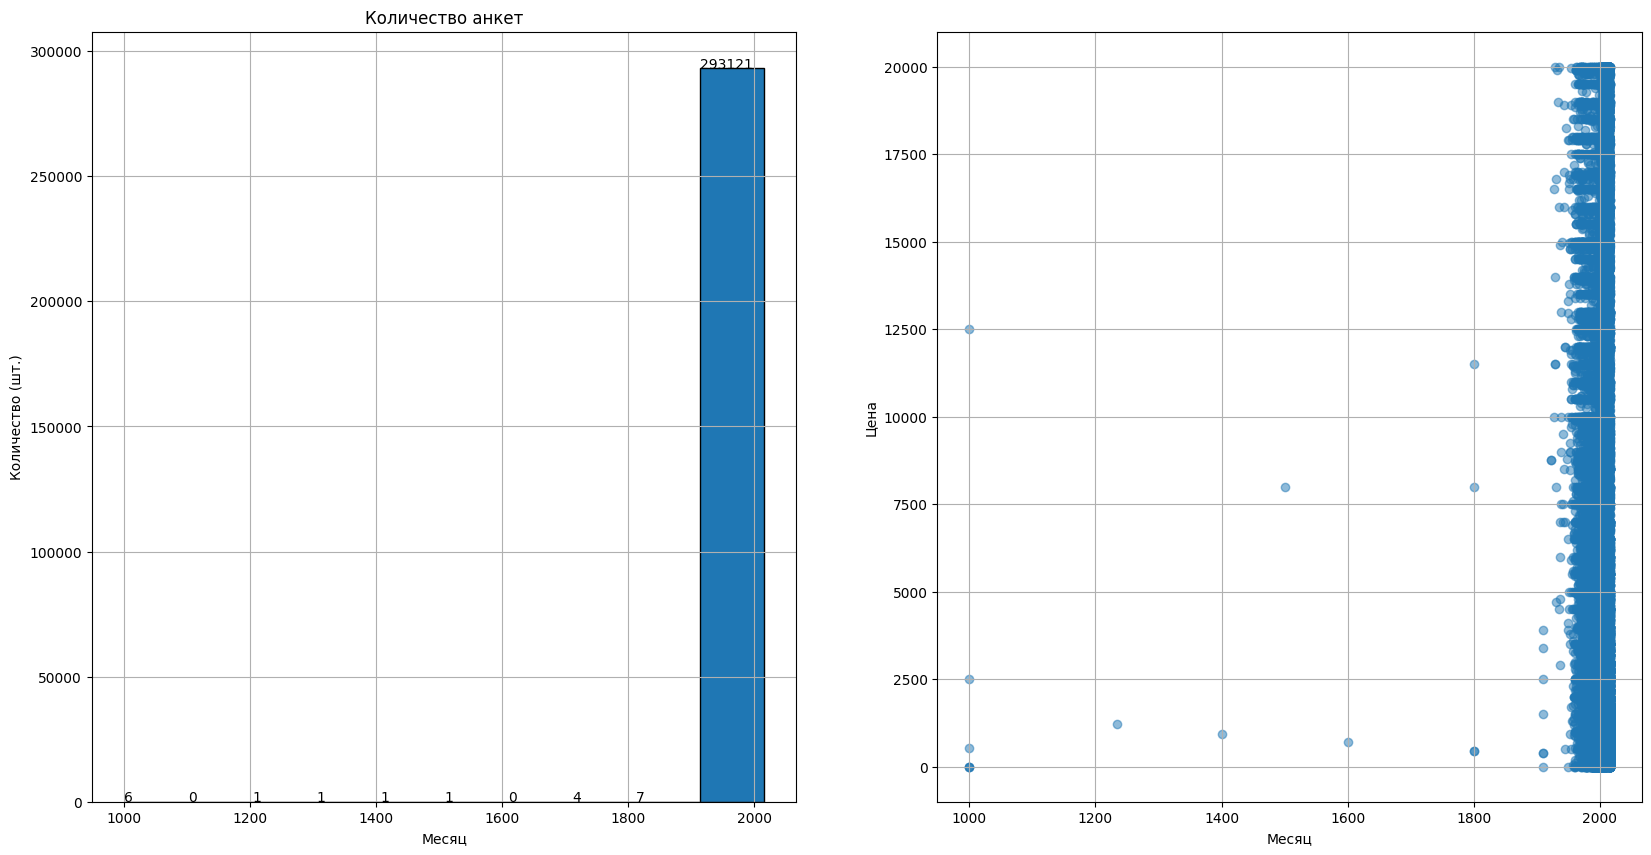

In [51]:
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10)
) 
    
axs[0].hist(
    autos['RegistrationYear'],
    edgecolor='black')
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Месяц')

axs[1].scatter(autos['RegistrationYear'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Месяц');

Удалим строки с годом регистрации ранее 1920

In [52]:
autos = autos.query('RegistrationYear > 1920')

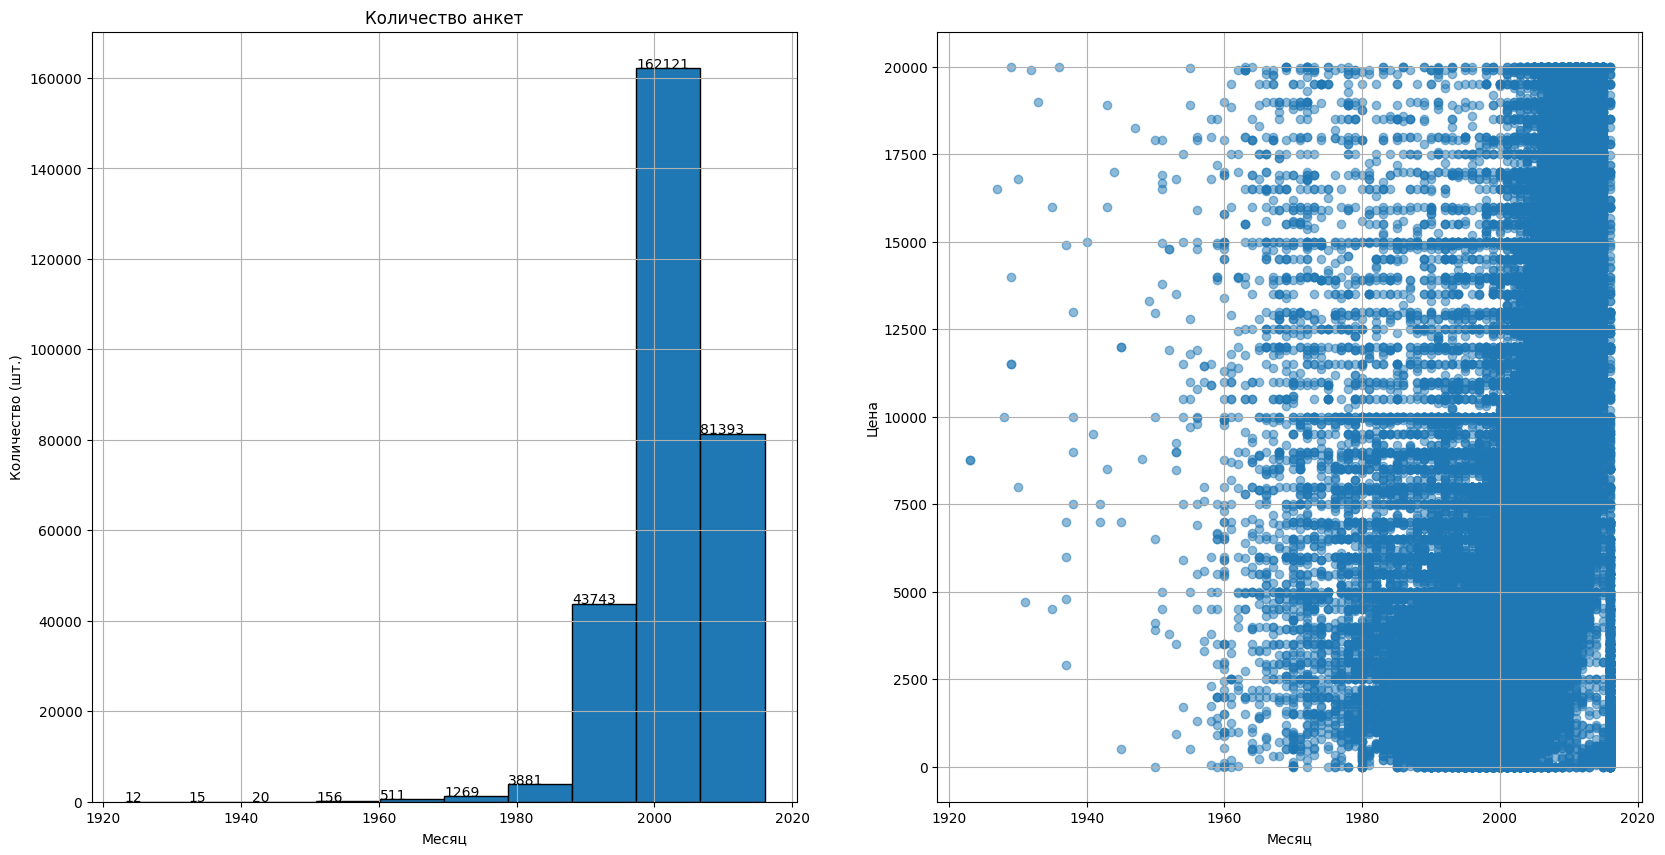

In [53]:
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10)
) 
    
axs[0].hist(
    autos['RegistrationYear'],
    edgecolor='black')
axs[0].grid(True)
for i in axs[0].patches:
    axs[0].annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
axs[0].set_title('Количество анкет')
axs[0].set_ylabel('Количество (шт.)')
axs[0].set_xlabel('Месяц')

axs[1].scatter(autos['RegistrationYear'], autos['Price'], alpha = 0.5)
axs[1].grid(True)
axs[1].set_ylabel('Цена')
axs[1].set_xlabel('Месяц');

In [54]:
autos.describe(percentiles=[0.1, 0.2,0.3, 0.4, 0.6,  0.7, 0.8, 0.9])

Price  RegistrationYear          Power      Kilometer  \
count  293121.00000     293121.000000  293121.000000  293121.000000   
mean     4881.50576       2002.646603     124.443445  128170.397208   
min         1.00000       1923.000000       1.000000    5000.000000   
10%       650.00000       1996.000000      60.000000   70000.000000   
20%      1100.00000       1998.000000      75.000000  100000.000000   
30%      1600.00000       2000.000000      90.000000  125000.000000   
40%      2300.00000       2001.000000     101.000000  150000.000000   
50%      3200.00000       2003.000000     113.000000  150000.000000   
60%      4400.00000       2005.000000     125.000000  150000.000000   
70%      5999.00000       2006.000000     140.000000  150000.000000   
80%      8300.00000       2008.000000     160.000000  150000.000000   
90%     12000.00000       2010.000000     190.000000  150000.000000   
max     20000.00000       2016.000000   20000.000000  150000.000000   
std      4620.32371          6.411953     189.027763   36855.532394   

       RegistrationMonth                    DateCreated      num_nulls  \
count      293121.000000                         293121  293121.000000   
mean            5.970323  2016-03-20 19:23:27.731278080       0.269155   
min             0.000000            2015-03-20 00:00:00       0.000000   
10%             1.000000            2016-03-08 00:00:00       0.000000   
20%             3.000000            2016-03-11 00:00:00       0.000000   
30%             4.000000            2016-03-15 00:00:00       0.000000   
40%             5.000000            2016-03-18 00:00:00       0.000000   
50%             6.000000            2016-03-21 00:00:00       0.000000   
60%             7.000000            2016-03-24 00:00:00       0.000000   
70%             8.000000            2016-03-27 00:00:00       0.000000   
80%            10.000000            2016-03-30 00:00:00       1.000000   
90%            11.000000            2016-04-02 00:00:00       1.000000   
max            12.000000            2016-04-07 00:00:00       5.000000   
std             3.590540                            NaN       0.605132   

       DateCreated_ym  DateCreated_y  DateCreated_m  Registration_ym  
count   293121.000000  293121.000000  293121.000000    293121.000000  
mean      2016.316044    2015.999918       3.161258      2003.243636  
min       2015.300000    2015.000000       1.000000      1923.000000  
10%       2016.300000    2016.000000       3.000000      1996.200000  
20%       2016.300000    2016.000000       3.000000      1998.700000  
30%       2016.300000    2016.000000       3.000000      2000.200000  
40%       2016.300000    2016.000000       3.000000      2001.900000  
50%       2016.300000    2016.000000       3.000000      2003.500000  
60%       2016.300000    2016.000000       3.000000      2005.200000  
70%       2016.300000    2016.000000       3.000000      2006.800000  
80%       2016.300000    2016.000000       3.000000      2008.600000  
90%       2016.400000    2016.000000       4.000000      2010.900000  
max       2016.400000    2016.000000      12.000000      2016.400000  
std          0.037325       0.009048       0.378440         6.434815

##### Обработка неинформативных признаков (продолжение)

In [55]:
autos = autos.drop(['DateCreated', 'DateCreated_ym', 'DateCreated_y','DateCreated_m', 'Registration_ym'],axis=1)

In [56]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293121 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              293121 non-null  int64 
 1   VehicleType        285797 non-null  object
 2   RegistrationYear   293121 non-null  int64 
 3   Gearbox            287930 non-null  object
 4   Power              293121 non-null  int64 
 5   Model              282333 non-null  object
 6   Kilometer          293121 non-null  int64 
 7   RegistrationMonth  293121 non-null  int64 
 8   FuelType           279132 non-null  object
 9   Brand              293121 non-null  object
 10  Repaired           251518 non-null  object
 11  num_nulls          293121 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.1+ MB


Может нулевой месяц ставят, когда не удается узнать регистрации автомобиля точнее года.

#### Power

Распределим автомобили по категориям в которые объеденим автомобили одной марки и одного бренда зарегестрированные в определенный период времени 

In [57]:
autos['Brand'] = autos['Brand'].fillna('unknown_b')
autos['Model'] = autos['Model'].fillna('unknown_m')
autos['Repaired'] = autos['Repaired'].fillna('unknown_rep')

Распределим машины по пятилеткам

In [58]:
autos.loc[autos['RegistrationYear'] < 1987, 'year_cat'] = 'old'
autos.loc[(2012 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 2016) , 'year_cat'] = '2012-2016'
autos.loc[(2007 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 2011) , 'year_cat'] = '2011-2007'
autos.loc[(2002 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 2006) , 'year_cat'] = '2002-2006'
autos.loc[(1997 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 2001) , 'year_cat'] = '1997-2001'
autos.loc[(1992 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 1996) , 'year_cat'] = '1992-1996'
autos.loc[(1987 <= autos['RegistrationYear']) &(autos['RegistrationYear']<= 1991) , 'year_cat'] = '1987-1991'

Создадим столбец объдиняющий бренд, модель и период регистрации

In [59]:
autos['category1'] = autos['Brand'] +' ' + autos['Model'] + ' ' +  autos['year_cat']
autos['category1'].nunique()

1629

Создадим столбецы со значениями мощностей с которых начинаются выбросы для каждой категории

In [60]:
for i in autos['category1'].unique():
    Q1_power = autos.query('category1 == @i and Power > 0')['Power'].quantile(0.25)
    Q3_power = autos.query('category1 == @i and Power > 0')['Power'].quantile(0.75)
    dq = 1.5*(Q3_power-Q1_power)
    power_max = Q3_power + dq
    power_min = Q1_power - dq
    autos.loc[ i == autos['category1'], 'power_max'] = power_max
    autos.loc[ i == autos['category1'], 'power_min'] = power_min

Заполним получившиеся пропуски, в категориях в где все мощности нулевые, нулями

In [61]:
autos['power_max'].fillna(0)
autos['power_max'].nunique()

733

In [62]:
autos['power_min'].fillna(0)
autos['power_min'].nunique()

639

Удалим строки в которых мощность машины является выбросом для ее категории

In [63]:
autos = autos.query('Power <=  power_max')
autos = autos.query('power_min <=  Power or Power == 0')
autos.describe(percentiles=[0.1, 0.2,0.3, 0.4, 0.6,  0.7, 0.8, 0.9])

Price  RegistrationYear          Power      Kilometer  \
count  271249.000000     271249.000000  271249.000000  271249.000000   
mean     4792.589860       2002.645750     117.583055  128270.389937   
std      4537.345556          6.430555      49.713654   36773.446359   
min         1.000000       1923.000000       1.000000    5000.000000   
10%       650.000000       1996.000000      60.000000   70000.000000   
20%      1099.000000       1998.000000      75.000000  100000.000000   
30%      1600.000000       2000.000000      87.000000  125000.000000   
40%      2299.000000       2001.000000     101.000000  150000.000000   
50%      3150.000000       2003.000000     110.000000  150000.000000   
60%      4300.000000       2005.000000     122.000000  150000.000000   
70%      5950.000000       2006.000000     140.000000  150000.000000   
80%      8000.000000       2008.000000     150.000000  150000.000000   
90%     11900.000000       2010.000000     177.000000  150000.000000   
max     20000.000000       2016.000000    1992.000000  150000.000000   

       RegistrationMonth      num_nulls      power_max      power_min  
count      271249.000000  271249.000000  271249.000000  271249.000000  
mean            5.975510       0.267942     182.374049      54.301153  
std             3.588139       0.603877      77.611564      38.850191  
min             0.000000       0.000000       5.000000    -339.000000  
10%             1.000000       0.000000      85.000000      21.000000  
20%             3.000000       0.000000     112.500000      30.000000  
30%             4.000000       0.000000     140.000000      36.000000  
40%             5.000000       0.000000     156.500000      43.500000  
50%             6.000000       0.000000     176.000000      52.500000  
60%             7.000000       0.000000     192.500000      60.000000  
70%             8.000000       0.000000     210.500000      68.500000  
80%            10.000000       1.000000     237.500000      84.500000  
90%            11.000000       1.000000     278.500000     102.500000  
max            12.000000       5.000000    1992.000000    1992.000000

In [64]:
df1 = autos.query('Power != 0').groupby(['category1']).agg(
    val_count=('power_max','count'), 
    val_median = ('Power','median'),
    val_max = ('Power','max'),
    val_min = ('Power','min'))

In [65]:
df1.sort_values(by = 'val_max', ascending = False).head(50)

val_count  val_median  val_max  \
category1                                                                
volkswagen touareg 1992-1996                    1      1992.0     1992   
opel astra old                                  1      1000.0     1000   
audi other 2012-2016                            7       330.0      610   
lancia unknown_m 2002-2006                      3        75.0      602   
mercedes_benz s_klasse 2012-2016                2       394.5      585   
bmw m_reihe 2012-2016                           3       431.0      560   
audi other 2002-2006                          315       232.0      510   
bmw m_reihe 2011-2007                           4       507.0      507   
mercedes_benz cl 2002-2006                     93       224.0      500   
mercedes_benz g_klasse 2011-2007                2       362.0      500   
mercedes_benz sl 2011-2007                      3       387.0      500   
mercedes_benz other 2002-2006                 475       170.0      500   
porsche cayenne 2011-2007                      29       340.0      500   
audi a8 2002-2006                             227       275.0      475   
porsche cayenne 2002-2006                     178       340.0      450   
audi other 2011-2007                          181       265.0      450   
bmw 7er 2002-2006                             294       272.0      445   
bmw m_reihe 1997-2001                          38       400.0      440   
porsche 911 2012-2016                           1       430.0      430   
jeep grand 2011-2007                           20       218.0      426   
volkswagen phaeton 2002-2006                  111       241.0      420   
audi a8 1997-2001                             102       299.0      420   
ford galaxy old                                 1       408.0      408   
mercedes_benz sl 1992-1996                    107       231.0      400   
sonstige_autos unknown_m 2002-2006            363       165.0      400   
mercedes_benz cl 1992-1996                     10       394.0      400   
mercedes_benz s_klasse 1992-1996               59       279.0      396   
mercedes_benz sl 1997-2001                     56       233.0      394   
chevrolet other old                           101       175.0      390   
land_rover range_rover_sport 2011-2007         34       231.0      390   
mercedes_benz sl 1987-1991                     21       231.0      390   
bmw 7er 1997-2001                             254       235.0      387   
mercedes_benz s_klasse 2002-2006              170       245.0      387   
mercedes_benz cl 2011-2007                     11       215.0      387   
sonstige_autos unknown_m 1992-1996            144       148.0      387   
porsche cayenne 2012-2016                       2       313.5      382   
audi other 1997-2001                          226       209.0      381   
mercedes_benz s_klasse 1997-2001              307       250.0      381   
bmw other 2012-2016                             9       143.0      380   
bmw 6er 2011-2007                              14       286.0      367   
bmw 7er 2012-2016                               4       306.0      367   
chrysler other old                             17       180.0      363   
jaguar other 2002-2006                         18       261.0      363   
sonstige_autos unknown_m 1997-2001            295       125.0      362   
bmw x_reihe 2011-2007                         634       177.0      355   
porsche unknown_m 2002-2006                     2       300.0      350   
ford mustang old                               32       200.0      350   
bmw m_reihe 1992-1996                          11       321.0      350   
chevrolet unknown_m 1997-2001                   4       297.5      350   
chevrolet other 1997-2001                     123       193.0      349   

                                        val_min  
category1                                        
volkswagen touareg 1992-1996               1992  
opel astra old                           

In [66]:
df1.sort_values(by = 'val_min').head(50)

val_count  val_median  val_max  val_min
category1                                                                  
sonstige_autos unknown_m 1997-2001        295       125.0      362        1
sonstige_autos unknown_m 2002-2006        363       165.0      400        1
sonstige_autos unknown_m 2012-2016         87       101.0      264        1
fiat other 1997-2001                      450       103.0      200        1
audi other 2012-2016                        7       330.0      610        1
hyundai unknown_m 2002-2006                48       103.0      180        2
sonstige_autos unknown_m 1987-1991         99       110.0      300        3
sonstige_autos unknown_m old              478        80.0      349        3
sonstige_autos unknown_m 1992-1996        144       148.0      387        4
opel unknown_m 1992-1996                  143        65.0      136        4
seat other 1992-1996                       23        40.0       75        5
seat leon old                               1         5.0        5        5
citroen unknown_m 2002-2006                48       105.0      207        6
volkswagen unknown_m old                   46        69.0      116        6
citroen c3 old                              2         9.5       11        8
opel other old                            218        95.0      200        9
citroen other 1997-2001                   564        90.0      163        9
fiat unknown_m 1987-1991                    4        43.0       75        9
audi unknown_m 1997-2001                  262       150.0      280       10
bmw other old                              53       100.0      220       12
fiat other old                            100        75.5      131       13
toyota other 1997-2001                    244       107.0      224       14
fiat 500 old                               67        18.0       29       15
citroen other old                          75        36.0      136       15
nissan unknown_m 2011-2007                 14       145.0      330       16
fiat other 1992-1996                      213        75.0      193       17
renault other old                          57        34.0       92       20
citroen other 1987-1991                    50        49.5      122       20
trabant other old                          19        26.0       26       20
volkswagen transporter 1992-1996          847        78.0      151       20
audi other old                             23        90.0      220       23
fiat other 1987-1991                       31        55.0      105       23
peugeot other old                           5        54.0       75       23
fiat seicento old                           2        23.0       23       23
fiat unknown_m 1992-1996                   14        55.0       90       24
ford other old                            153       100.0      286       24
subaru unknown_m 1992-1996                  4        91.5      116       25
trabant 601 2012-2016                       1        26.0       26       26
trabant 601 1992-1996                       1        26.0       26       26
trabant 601 1987-1991                     109        26.0       26       26
trabant 601 old                            95        26.0       26       26
trabant unknown_m 1987-1991                11        26.0       26       26
trabant unknown_m old                      15        26.0       26       26
citroen c2 old                              1        27.0       27       27
volkswagen other old                      100        50.0      100       27
fiat panda old                              2        37.5       45       30
citroen other 1992-1996                    90        75.0      150       30
mercedes_benz other old                   515       120.0      245       30
smart fortwo 2002-2006                   1056        54.0       85       30
volkswagen kaefer old                     258        43.0       68       30

В общем удалим еще строки с мощностью больше 700 и на этом, кажется, придется остановится


In [67]:
autos = autos.query('Power <= 700')

#### Price

Удалим выбросы по ценам

In [68]:
autos['category2'] = autos['category1'] + ' ' +  autos['Repaired']
autos['category2'].nunique()

4013

In [69]:
for i in autos['category2'].unique():
    autos.loc[ i == autos['category2'], 'price_median'] = autos.query('category2 == @i')['Price'].median()

In [70]:
for i in autos['category2'].unique():
    Q1_price = autos.query('category2 == @i')['Price'].quantile(0.25)
    Q3_price = autos.query('category2 == @i')['Price'].quantile(0.75)
    dq = 1.5*(Q3_price-Q1_price)
    price_max = Q3_price + dq
    price_min = Q1_price - dq
    autos.loc[ i == autos['category2'], 'price_max'] = price_max
    autos.loc[ i == autos['category2'], 'price_min'] = price_min

In [71]:
autos = autos.query('Price <=  price_max')
autos = autos.query('price_min <=  Price')
autos.describe(percentiles=[0.1, 0.2,0.3, 0.4, 0.6,  0.7, 0.8, 0.9])

Price  RegistrationYear          Power      Kilometer  \
count  263649.000000     263649.000000  263649.000000  263649.000000   
mean     4734.110469       2002.666856     117.293519  128678.944354   
std      4505.868738          6.378999      49.403581   36474.350216   
min         1.000000       1923.000000       1.000000    5000.000000   
10%       650.000000       1996.000000      60.000000   70000.000000   
20%      1000.000000       1998.000000      75.000000  100000.000000   
30%      1550.000000       2000.000000      87.000000  125000.000000   
40%      2200.000000       2001.000000     101.000000  150000.000000   
50%      3000.000000       2003.000000     110.000000  150000.000000   
60%      4200.000000       2005.000000     122.000000  150000.000000   
70%      5900.000000       2006.000000     140.000000  150000.000000   
80%      7999.000000       2008.000000     150.000000  150000.000000   
90%     11800.000000       2010.000000     177.000000  150000.000000   
max     20000.000000       2016.000000     610.000000  150000.000000   

       RegistrationMonth      num_nulls      power_max     power_min  \
count      263649.000000  263649.000000  263649.000000  263649.00000   
mean            5.978035       0.264230     182.483305      54.43578   
std             3.585751       0.599827      77.626911      38.62811   
min             0.000000       0.000000       5.000000    -339.00000   
10%             1.000000       0.000000      85.000000      21.00000   
20%             3.000000       0.000000     112.500000      30.00000   
30%             4.000000       0.000000     140.000000      36.00000   
40%             5.000000       0.000000     157.000000      43.62500   
50%             6.000000       0.000000     176.000000      52.50000   
60%             7.000000       0.000000     192.500000      60.00000   
70%             8.000000       0.000000     210.500000      68.50000   
80%            10.000000       1.000000     237.500000      84.50000   
90%            11.000000       1.000000     278.500000     102.50000   
max            12.000000       5.000000     951.750000     430.00000   

        price_median      price_max      price_min  
count  263649.000000  263649.000000  263649.000000  
mean     4588.939173    9496.811226     -76.403753  
std      4029.602874    7211.233792    2517.828315  
min         1.000000       1.000000  -26467.625000  
10%       869.000000    2150.000000   -1876.875000  
20%      1200.000000    2975.000000    -999.250000  
30%      1700.000000    4075.000000    -745.500000  
40%      2299.000000    5500.000000    -521.250000  
50%      2950.000000    7104.875000    -325.000000  
60%      4399.000000    9112.500000    -150.000000  
70%      5900.000000   12631.625000     126.125000  
80%      7970.000000   15650.000000     970.750000  
90%     10900.000000   21850.000000    2275.000000  
max     20000.000000   47079.375000   20000.000000

#### Удалим вспомогательные столбцы

In [72]:
autos = autos.drop(
    ['year_cat', 'category1','power_max','power_min','category2','price_median','price_max', 'price_min', 'num_nulls'],
     axis=1)

In [73]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263649 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              263649 non-null  int64 
 1   VehicleType        257601 non-null  object
 2   RegistrationYear   263649 non-null  int64 
 3   Gearbox            259082 non-null  object
 4   Power              263649 non-null  int64 
 5   Model              263649 non-null  object
 6   Kilometer          263649 non-null  int64 
 7   RegistrationMonth  263649 non-null  int64 
 8   FuelType           251380 non-null  object
 9   Brand              263649 non-null  object
 10  Repaired           263649 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.1+ MB


#### Обработка дубликатов

In [74]:
autos.duplicated().sum()

21190

In [75]:
autos = autos.drop_duplicates()
autos.shape

(242459, 11)

### Изучим количественные данные

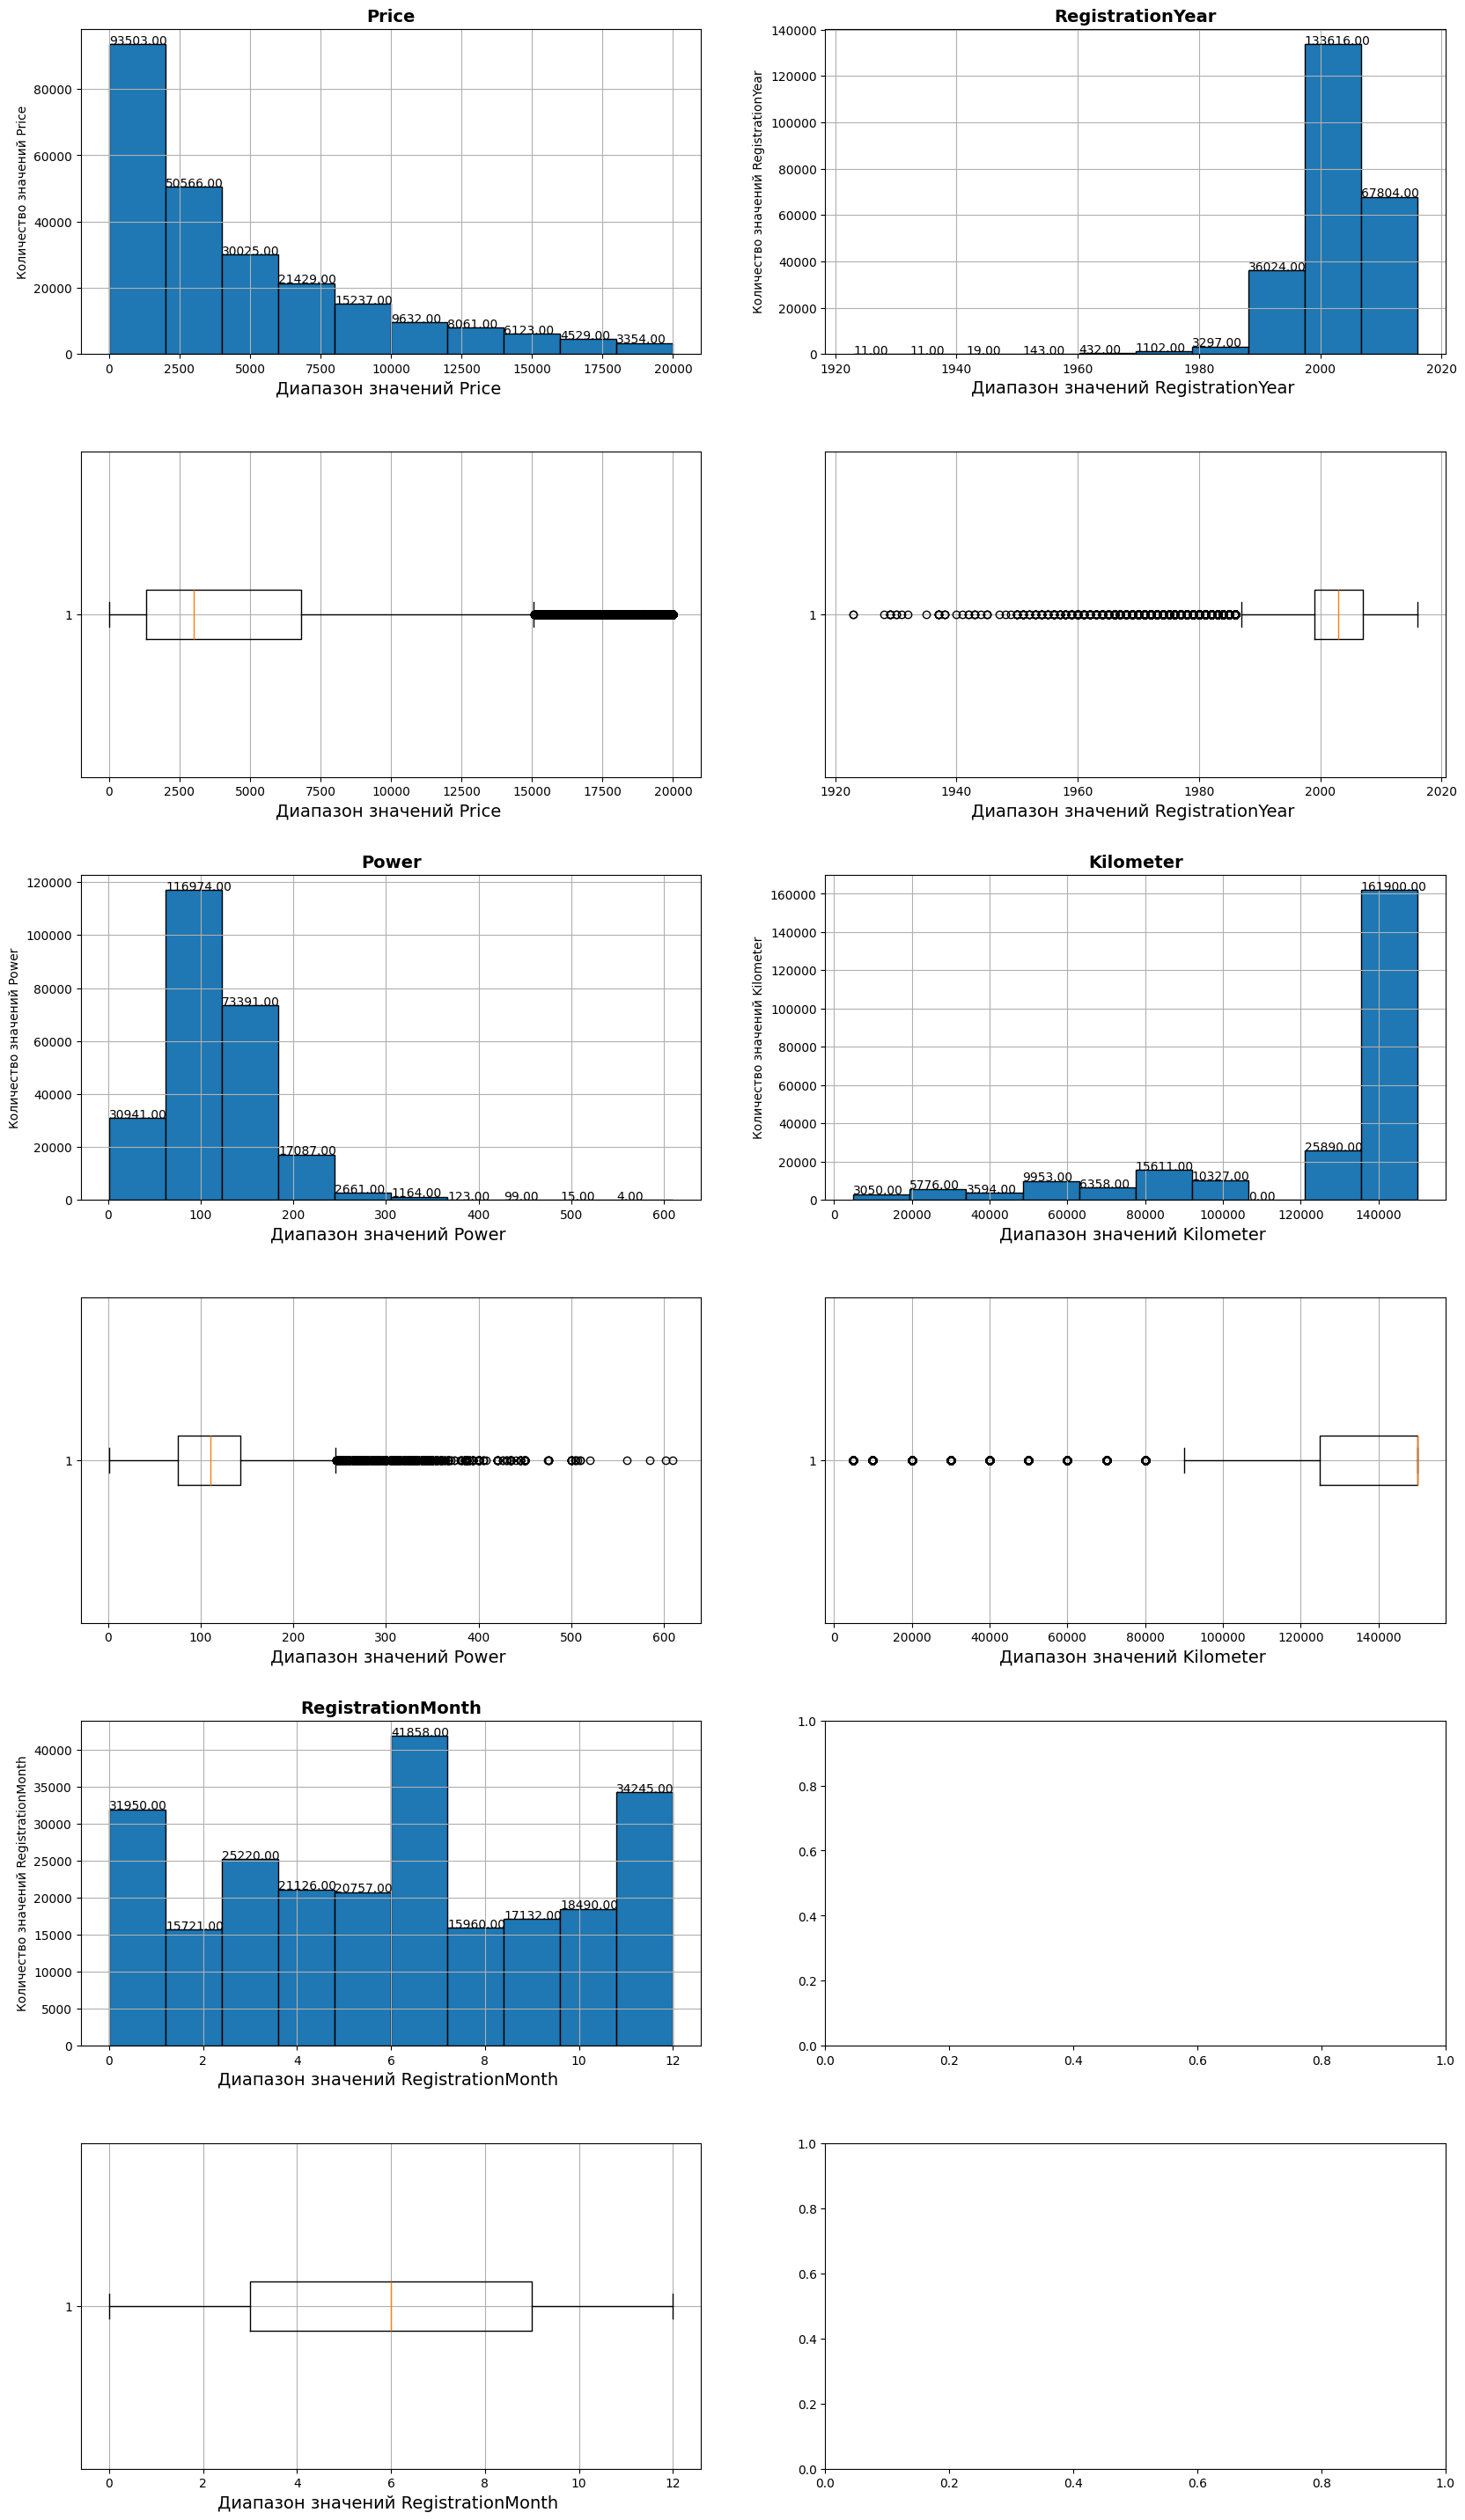

In [76]:
hist_boxplot(autos, 2)

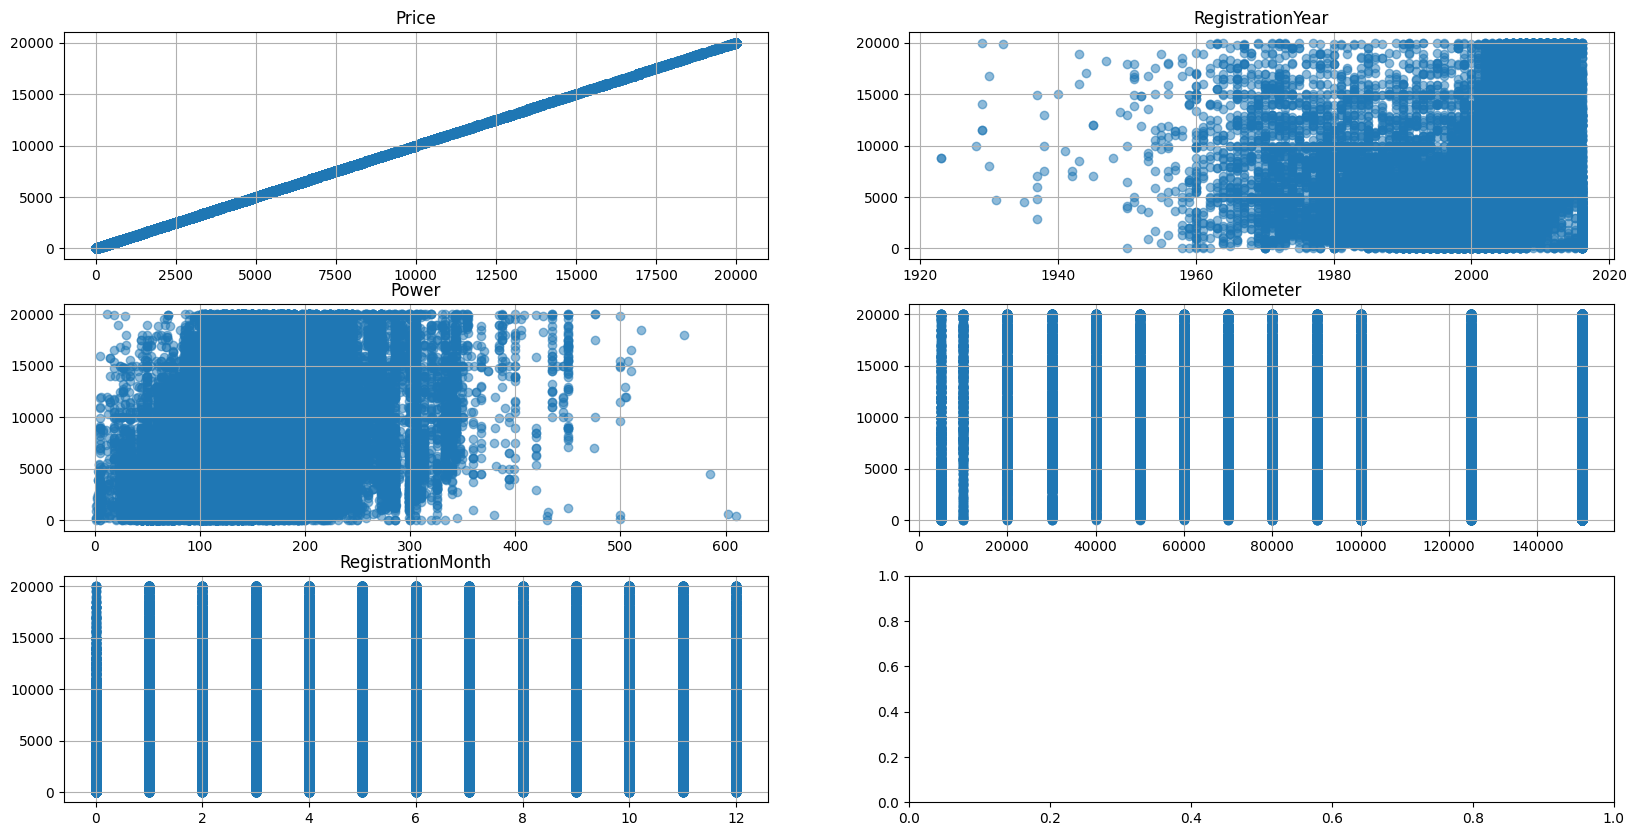

In [77]:
scatter(autos, 'Price', 2)

### Месяц регистрации (продолжение)

In [78]:
autos_month = autos.pivot_table(index='RegistrationMonth', values ='Price', aggfunc = ['count','mean', 'median'])
autos_month

count         mean  median
                   Price        Price   Price
RegistrationMonth                            
0                  15127  2216.890990  1200.0
1                  16823  4881.612376  3100.0
2                  15721  4728.942179  3000.0
3                  25220  4687.644251  2999.0
4                  21126  4944.280744  3300.0
5                  20757  4851.734740  3250.0
6                  22420  4882.999822  3250.0
7                  19438  4940.977570  3300.0
8                  15960  4840.793170  3200.0
9                  17132  5018.318118  3499.0
10                 18490  5013.432396  3450.0
11                 17033  5029.697822  3500.0
12                 17212  4787.219149  3200.0

In [79]:
autos.query('RegistrationMonth == 0').describe(percentiles=[0.02, 0.25, 0.5, 0.75, 0.9, 0.98])

Price  RegistrationYear         Power      Kilometer  \
count  15127.000000      15127.000000  15127.000000   15127.000000   
mean    2216.890990       2000.116084    105.915185  135684.207047   
std     2814.800215          7.355763     45.946875   34423.356946   
min        1.000000       1923.000000      1.000000    5000.000000   
2%       100.000000       1984.000000     45.000000    5000.000000   
25%      550.000000       1997.000000     75.000000  150000.000000   
50%     1200.000000       2000.000000    101.000000  150000.000000   
75%     2690.000000       2004.000000    133.000000  150000.000000   
90%     5500.000000       2009.000000    165.000000  150000.000000   
98%    11999.000000       2016.000000    220.000000  150000.000000   
max    20000.000000       2016.000000    585.000000  150000.000000   

       RegistrationMonth  
count            15127.0  
mean                 0.0  
std                  0.0  
min                  0.0  
2%                   0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
90%                  0.0  
98%                  0.0  
max                  0.0

In [80]:
autos.query('RegistrationMonth > 0').describe(percentiles=[0.02, 0.25, 0.5, 0.75, 0.9, 0.98])

Price  RegistrationYear          Power      Kilometer  \
count  227332.000000     227332.000000  227332.000000  227332.000000   
mean     4879.951230       2002.780392     117.881147  128181.910158   
std      4553.371365          6.328952      49.468554   36612.809830   
min         1.000000       1923.000000       1.000000    5000.000000   
2%        290.000000       1989.000000      50.000000   20000.000000   
25%      1400.000000       1999.000000      75.000000  125000.000000   
50%      3250.000000       2003.000000     110.000000  150000.000000   
75%      6999.000000       2007.000000     143.000000  150000.000000   
90%     11990.000000       2010.000000     177.000000  150000.000000   
98%     17500.000000       2013.000000     235.000000  150000.000000   
max     20000.000000       2016.000000     610.000000  150000.000000   

       RegistrationMonth  
count      227332.000000  
mean            6.349634  
std             3.352693  
min             1.000000  
2%              1.000000  
25%             3.000000  
50%             6.000000  
75%             9.000000  
90%            11.000000  
98%            12.000000  
max            12.000000

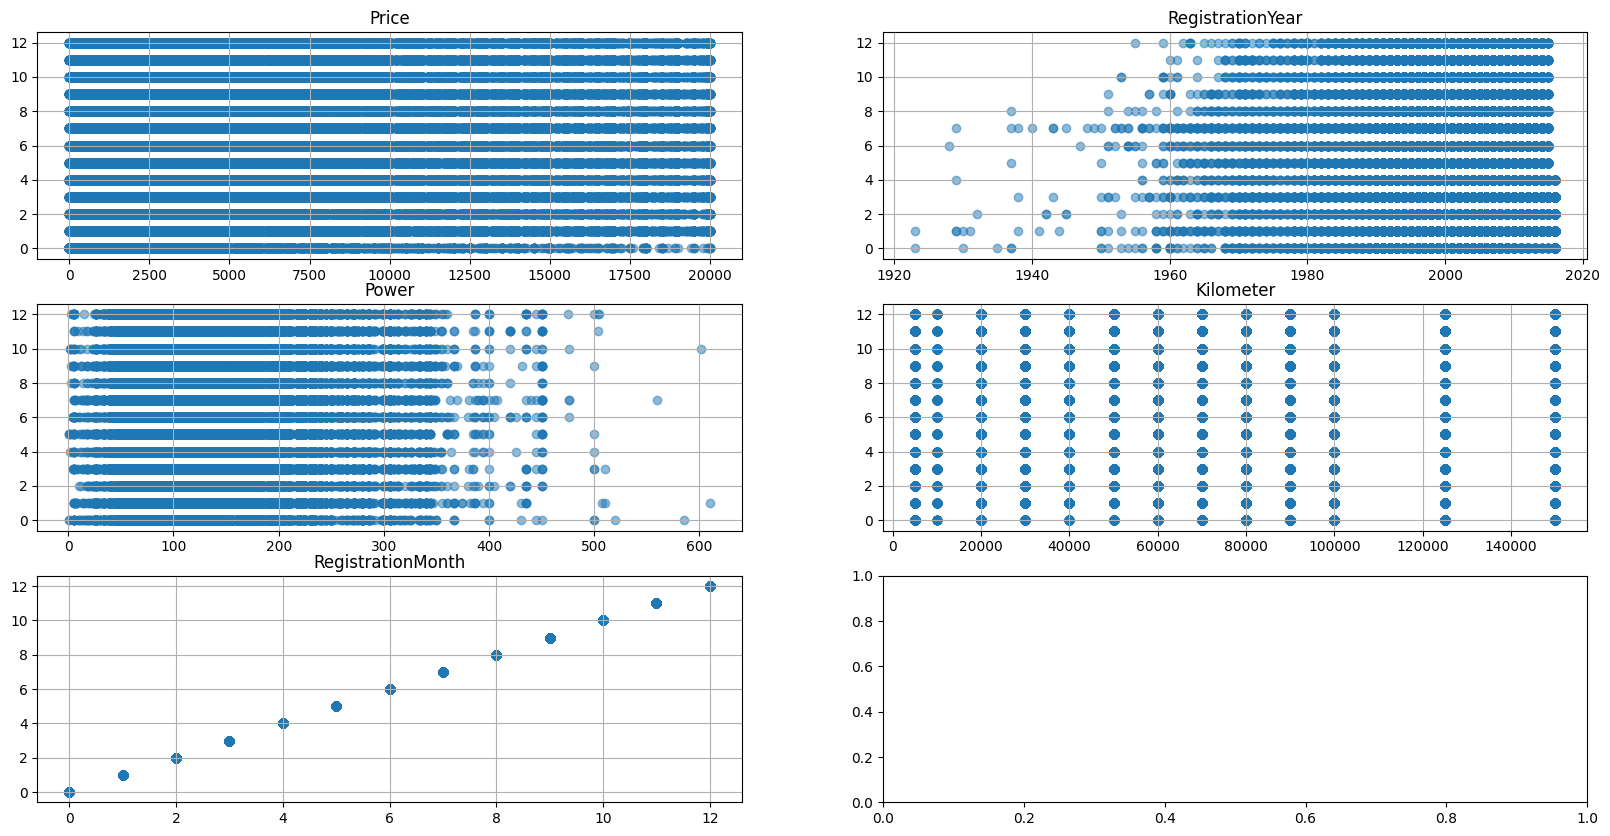

In [81]:
scatter(autos, 'RegistrationMonth', 2)

После обработки аномальных значений не удалось выявить каких либо очевидных закономеростей связанных с нулевым месяцем кроме цены. Остальные месяцы не оказывают существенного воздействия на цену. Вероятно, строки с нулевым месяцем ошибочны. Удалим строки с нулевым месяцем, а затем удалим столбец RegistrationMonth

In [82]:
autos = autos.query('RegistrationMonth > 0')

In [83]:
autos = autos.drop('RegistrationMonth', axis = 1)

#### Пропуски в категориальных переменных, которые  должны влиять на цену

In [84]:
autos['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [85]:
autos['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [86]:
autos['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [87]:
autos['Repaired'].unique()

array(['yes', 'unknown_rep', 'no'], dtype=object)

Заменим все пропуски в категориальным переменных на 'unknown'

In [88]:
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')
autos['Gearbox'] = autos['Gearbox'].fillna('unknown')
autos['FuelType'] = autos['FuelType'].fillna('unknown')
autos['Repaired'] = autos['Repaired'].fillna('unknown')

In [89]:
autos.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [90]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227332 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             227332 non-null  int64 
 1   VehicleType       227332 non-null  object
 2   RegistrationYear  227332 non-null  int64 
 3   Gearbox           227332 non-null  object
 4   Power             227332 non-null  int64 
 5   Model             227332 non-null  object
 6   Kilometer         227332 non-null  int64 
 7   FuelType          227332 non-null  object
 8   Brand             227332 non-null  object
 9   Repaired          227332 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.1+ MB


## Обучение моделей

### Раздление выборки на тестовую и тренировочную

In [91]:
features = autos.drop('Price', axis=1)
target = autos['Price']


In [92]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [93]:
print(features_train.shape,target_train.shape)
print(features_test.shape,target_test.shape)

(170499, 9) (170499,)
(56833, 9) (56833,)


In [94]:
print(target_train.min(), target_train.max())

1 20000


### Обучение

In [95]:
scoring_inner_cv = get_scorer('neg_root_mean_squared_error')

#### Линейная регрессия

In [96]:
transformer = make_column_transformer(
     (OneHotEncoder(drop='first', handle_unknown="ignore"), 
         ['VehicleType','RegistrationYear',
          'Model', 'Kilometer', 'Gearbox',
          'FuelType', 'Brand','Repaired']),
     remainder='passthrough')

In [97]:
model_linear = make_pipeline(transformer, LinearRegression())
parameters = {}
regr_linear = RandomizedSearchCV(
    model_linear,parameters, scoring=scoring_inner_cv, cv=None, return_train_score = True
    ).fit(features_train, target_train)


C:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during

In [98]:
lin_train_score = abs(regr_linear.best_score_) #замеряем RMSE на  кросс-валидации

In [99]:
model_lin_best = regr_linear.best_estimator_

In [100]:
start = time.time()

model_lin_best.fit(features_train, target_train) #замеряем время обучения

end = time.time()
time_lin_fit = end - start
time_lin_fit

2.3294520378112793

In [101]:
start = time.time()

model_lin_best.predict(features_train)

end = time.time()
time_lin_predict = end - start
time_lin_predict

0.5165824890136719

#### Обработка категориальных переменных для моделей DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor

In [102]:
ordin_en = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = 99999)

In [103]:
list_col = ['VehicleType','RegistrationYear',
          'Model', 'Kilometer', 'Gearbox',
          'FuelType', 'Brand','Repaired']

In [104]:
ordin_en.fit(features_train[list_col])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999)

In [105]:
features_train[list_col] = ordin_en.transform(features_train[list_col])

In [106]:
features_train

VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
56402           5.0              71.0      1.0     67  148.0        9.0   
176768          8.0              73.0      1.0    102   62.0       11.0   
290392          8.0              71.0      1.0     90   42.0        7.0   
131429          5.0              68.0      1.0     60  225.0       12.0   
245865          8.0              64.0      1.0    105   42.0       12.0   
...             ...               ...      ...    ...    ...        ...   
126540          4.0              58.0      1.0     90   20.0       12.0   
201189          1.0              64.0      0.0    218   76.0       11.0   
196517          5.0              77.0      1.0     90   26.0        7.0   
114234          1.0              63.0      0.0    197  206.0       12.0   
337945          8.0              67.0      1.0    163   31.0       12.0   

        FuelType  Brand  Repaired  
56402        6.0    3.0       0.0  
176768       4.0   38.0       0.0  
290392       6.0   24.0       0.0  
131429       6.0   27.0       1.0  
245865       6.0   24.0       1.0  
...          ...    ...       ...  
126540       6.0    1.0       0.0  
201189       6.0   20.0       0.0  
196517       2.0    1.0       0.0  
114234       6.0   20.0       1.0  
337945       2.0    1.0       0.0  

[170499 rows x 9 columns]

In [107]:
features_test[list_col] = ordin_en.transform(features_test[list_col])
features_test

VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
121575          5.0              60.0      1.0     55  173.0       12.0   
73241           4.0              63.0      1.0     75  116.0       12.0   
210594          5.0              76.0      1.0     75   75.0        2.0   
210957          1.0              64.0      1.0    163  206.0       12.0   
61386           4.0              63.0      1.0     82   33.0       12.0   
...             ...               ...      ...    ...    ...        ...   
204102          2.0              59.0      1.0    102   11.0       12.0   
284032          0.0              69.0      1.0    120  197.0        8.0   
27610           4.0              67.0      0.0    170   11.0       12.0   
29685           2.0              65.0      1.0    116   11.0       12.0   
63204           8.0              70.0      0.0    140   29.0       12.0   

        FuelType  Brand  Repaired  
121575       7.0   38.0       0.0  
73241        6.0   38.0       1.0  
210594       6.0   27.0       1.0  
210957       6.0   20.0       0.0  
61386        6.0   20.0       0.0  
...          ...    ...       ...  
204102       6.0    2.0       0.0  
284032       2.0   27.0       0.0  
27610        6.0    2.0       0.0  
29685        6.0    2.0       1.0  
63204        2.0    1.0       0.0  

[56833 rows x 9 columns]

#### Древо решений

In [108]:
model_tree = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth':list(range(1, 25+1)),'min_samples_leaf': [1, 2, 3] }
regr_tree = RandomizedSearchCV(
   model_tree,parameters, scoring=scoring_inner_cv, cv=5, return_train_score = True
    ).fit(features_train, target_train)

In [109]:
tree_train_score = abs(regr_tree.best_score_) #замеряем RMSE на  кросс-валидации

In [110]:
model_tree_best = regr_tree.best_estimator_

In [111]:
start = time.time()

model_tree_best.fit(features_train, target_train) #замеряем время обучения

end = time.time()
time_tree_fit = end - start
time_tree_fit

0.6437981128692627

In [112]:
start = time.time()

model_tree_best.predict(features_train)

end = time.time()
time_tree_predict = end - start
time_tree_predict

0.08644700050354004

#### CatBoostRegressor

In [113]:
model_meow = CatBoostRegressor(random_state=12345,verbose=False)
parameters = {'learning_rate': (np.arange(3, 11, 1)/10).tolist(),
              'depth': np.arange(4, 11, 1).tolist()}
regr_meow = RandomizedSearchCV(model_meow,parameters, scoring=scoring_inner_cv, cv=5, return_train_score = True).fit(features_train, target_train)

In [114]:
meow_train_score = abs(regr_meow.best_score_) #замеряем RMSE на  кросс-валидации

In [115]:
model_meow_best = regr_meow.best_estimator_

In [116]:
start = time.time()

model_meow_best.fit(features_train, target_train) #замеряем время обучения

end = time.time()
time_meow_fit = end - start
time_meow_fit

18.24757218360901

In [118]:
start = time.time()

model_meow_best.predict(features_train)

end = time.time()
time_meow_predict = end - start

In [119]:
meow_test_score = scoring_inner_cv(model_meow_best, features_test, target_test)
meow_test_score

-1390.0869804824993

#### LGBMRegressor

In [120]:
estimator_lgbm = lgbm.LGBMRegressor(objective='regression',random_state=12345)

param_grid = {'learning_rate': [0.1, 0.01],
              'n_estimators': [50, 100, 150],
              'max_depth': [4, 6] }

regr_lgbm = RandomizedSearchCV(estimator=estimator_lgbm, param_distributions=param_grid, cv = 5, n_jobs=-1 ,verbose=0, scoring='neg_root_mean_squared_error')
regr_lgbm.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 170499, number of used features: 9
[LightGBM] [Info] Start training from score 4881.804667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='regression',
                                           random_state=12345),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [4, 6],
                                        'n_estimators': [50, 100, 150]},
                   scoring='neg_root_mean_squared_error')

In [121]:
lgbm_train_score = abs(regr_lgbm.best_score_) #замеряем RMSE на  кросс-валидации

In [122]:
model_lgbm_best = regr_lgbm.best_estimator_


In [123]:
model_lgbm_best

LGBMRegressor(max_depth=6, n_estimators=150, objective='regression',
              random_state=12345)

In [124]:
start = time.time()

model_lgbm_best.fit(features_train, target_train) #замеряем время обучения

end = time.time()
time_lgbm_fit = end - start
time_lgbm_fit

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 170499, number of used features: 9
[LightGBM] [Info] Start training from score 4881.804667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


3.0922253131866455

In [125]:
start = time.time()

model_lgbm_best.predict(features_train)

end = time.time()
time_lgbm_predict = end - start
time_lgbm_predict

0.9770369529724121

## Анализ моделей

In [126]:
data = np.array(
    [['LinearRegression', time_lin_fit, time_lin_predict, lin_train_score],
     ['DecisionTreeRegressor', time_tree_fit, time_tree_predict, tree_train_score],
     ['CatBoostRegressor', time_meow_fit, time_meow_predict, meow_train_score],
     ['LGBMRegressor', time_lgbm_fit, time_lgbm_predict, lgbm_train_score]]    
     )
    
df = pd.DataFrame(data=data, columns=["Модель", "время обучения", "время предсказания", "RMSE обучения"])

df

Модель      время обучения   время предсказания  \
0       LinearRegression  2.3294520378112793   0.5165824890136719   
1  DecisionTreeRegressor  0.6437981128692627  0.08644700050354004   
2      CatBoostRegressor   18.24757218360901  0.09359478950500488   
3          LGBMRegressor  3.0922253131866455   0.9770369529724121   

        RMSE обучения  
0  1920.3518850598261  
1   1698.647595863869  
2  1408.3674310238855  
3    1489.13014852096

Наилучшей моделей по точности является CatBoostRegressor, однако время ее обучения значительно превышает остальные.
Допустимые по точности результаты показали все модели

### Важность признаков лучшей модели

In [127]:
data1 = pd.DataFrame({'feature_importance': model_meow_best.get_feature_importance(), 
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data1

feature_importance     feature_names
1           37.012594  RegistrationYear
3           28.171854             Power
7           11.445821             Brand
5            7.136956         Kilometer
0            5.698350       VehicleType
4            5.310395             Model
8            3.032600          Repaired
6            1.308306          FuelType
2            0.883123           Gearbox

### Проверка лучшей модели на тестовой выборке

In [128]:
start = time.time()

test_result_meow = model_meow_best.predict(features_test)

end = time.time()
time_test_meow_predict = end - start
time_test_meow_predict

0.05586600303649902

In [129]:
meow_test_score = scoring_inner_cv(model_meow_best, features_test, target_test)
meow_test_score

-1390.0869804824993

In [130]:
print('Время предсказания на тестовой выборке = ', time_test_meow_predict)
print('Точность предсказания на тестовой выборке = ', abs(meow_test_score))

Время предсказания на тестовой выборке =  0.05586600303649902
Точность предсказания на тестовой выборке =  1390.0869804824993


### Проверка лучшей на адекватность

In [131]:
dummy_model = DummyRegressor(strategy="constant",constant = target_train.mean() )
dummy_model.fit(features_train, target_train)
dummy_prections = dummy_model.predict(features_test)

dummy_scorer = scoring_inner_cv(dummy_model, features_test, target_test)

In [132]:
print('Точность предсказания константной модели на тестовой выборке  = ', abs(dummy_scorer)) 

Точность предсказания константной модели на тестовой выборке  =  4552.038763568384


### Вывод

In [133]:
print('Лучшую точность показала модель CatBoostRegressor')

print(
    'Точность предсказания на тестовой выборке = ', 
    abs(meow_test_score), 'выше, чем у константной модели',
    abs(dummy_scorer), 'что свидетельсвует об адекватности модели')



Лучшую точность показала модель CatBoostRegressor
Точность предсказания на тестовой выборке =  1390.0869804824993 выше, чем у константной модели 4552.038763568384 что свидетельсвует об адекватности модели


## Вывод

Лучшую точность показала модель CatBoostRegressor
Точность предсказания на тестовой выборке =  1392.5765886592296 выше, чем у константной модели 4552.038763568384 что свидетельсвует об адекватности модели.

Наиболее важными признаками являются
- год регистрации
- мощность
- марка
- пробег